# Library

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import xgboost as xgb
import lightgbm as lgb

from datetime import datetime

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler


from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestRegressor, StackingClassifier
from sklearn.naive_bayes import GaussianNB



from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

# Data Loading

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [3]:
train

,gameId,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,blueWins
0,0,0,5,8,6,0,0,14536,17256,0
1,1,1,10,1,5,0,0,14536,17863,0
2,2,0,3,10,2,0,0,17409,17256,0
3,3,1,7,10,8,0,0,19558,18201,0
4,4,0,4,9,4,0,0,17409,17256,0
...,...,...,...,...,...,...,...,...,...,...
7995,9993,1,9,6,14,0,0,18513,18201,1
7996,9994,0,3,10,4,0,0,17381,19797,0
7997,9995,1,9,3,9,2,1,18274,18491,1
7998,9997,0,5,10,6,1,1,18274,18491,1


In [4]:
test

,gameId,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience
0,9,0,7,6,6,0,0,16961,18201
1,15,0,6,6,6,2,1,18513,18021
2,18,1,6,4,3,0,0,13475,17256
3,23,0,5,4,7,0,0,17409,17256
4,31,0,10,8,9,0,0,18117,18472
...,...,...,...,...,...,...,...,...,...
1995,9971,0,6,3,7,0,0,17409,17256
1996,9980,0,4,4,4,0,0,17409,17256
1997,9983,1,6,3,3,1,1,18513,18201
1998,9996,1,10,9,9,1,1,18513,18201


# Feature

- 各特長量の説明

| ヘッダ名称            | データ型 | 説明                                                       |
|---------------------|-------|----------------------------------------------------------|
| gameId             | int   | ゲームID                                                    |
| blueFirstBlood      | int   | ゲームの最初のキル。青チームが最初のキルを行った場合は1、それ以外の場合は0 |
| blueKills           | int   | 青チームによって殺された敵の数                                     |
| blueDeaths          | int   | 青チームの死亡者数                                            |
| blueAssists         | int   | 青チームのキルアシストの数                                      |
| blueEliteMonsters   | int   | 青チームによって殺されたエリートモンスターの数（ドラゴンとヘラルド）       |
| blueDragons         | int   | 青チームによって殺されたドラゴンの数                               |
| blueTotalGold       | int   | 青チームの得たゴールド合計                                       |
| blueTotalExperience | int   | 青チームの得た経験値合計                                       |
| blueWins            | int   | 目的変数（青チームが勝った場合は1、それ以外の場合は0。）                |


# Feature Engineering

- Add new feature

In [5]:
def add_features(df):
    df['assistRate'] = df['blueAssists'] / (df['blueKills'] + 1)
    df['blueHerald'] = (df['blueEliteMonsters'] - df['blueDragons']).clip(lower=0)
    df['eliteMonsterDragonRatio'] = df['blueEliteMonsters'] / (df['blueDragons'] + 1)
    df['logTotalGold'] = np.log1p(df['blueTotalGold'])
    df['logTotalExperience'] = np.log1p(df['blueTotalExperience'])
    df['firstBloodKillRatio'] = df['blueFirstBlood'] * df['blueKills']
    df['totalCombatPoints'] = df['blueKills'] + df['blueDeaths'] + df['blueAssists']

    total_combat_actions = df['blueKills'] + df['blueDeaths'] + df['blueAssists']
    df['killRatio'] = df['blueKills'] / total_combat_actions
    df['deathRatio'] = df['blueDeaths'] / total_combat_actions
    df['assistRatio'] = df['blueAssists'] / total_combat_actions

    df['teamStrength'] = df['blueKills'] + df['blueAssists'] + df['blueEliteMonsters']
    df['dragonKillImpact'] = df['blueDragons'] / (df['blueKills'] + 1)
    df['eliteMonsterUtilization'] = df['blueEliteMonsters'] / (df['blueKills'] + df['blueAssists'] + 1)
    df['goldExperienceRatio'] = df['blueTotalGold'] / (df['blueTotalExperience'] + 1)
    df['teamEfficiency'] = (df['blueKills'] + df['blueAssists'] + df['blueEliteMonsters']) / (df['blueDeaths'] + 1)
    df['killToMonsterRatio'] = df['blueKills'] / (df['blueEliteMonsters'] + 1)
    df['avgGoldPerKill'] = df['blueTotalGold'] / (df['blueKills'] + 1)
    df['expToKillRatio'] = df['blueTotalExperience'] / (df['blueKills'] + 1)
    df['killsMinusDeaths'] = df['blueKills'] - df['blueDeaths']
    df['killDeathRatio'] = df['blueKills'] / (df['blueKills'] + df['blueDeaths'])
    df['avgExperiencePerKill'] = df['blueTotalExperience'] / (df['blueKills'] + 1)
    df['killDeathDiff'] = (df['blueKills'] - df['blueDeaths']).clip(lower=0)
    df['eliteMonsterHeraldRatio'] = df['blueEliteMonsters'] / (df['blueHerald'] + 1)
    df['goldXexperience'] = np.log1p(df['blueTotalGold'] * df['blueTotalExperience'])
    df['goldPerKill'] = df['blueTotalGold'] / (df['blueKills'] + 1)  # ゼロ除算を防ぐために+1
    df['experiencePerKill'] = df['blueTotalExperience'] / (df['blueKills'] + 1)  # ゼロ除算を防ぐために+1
    df['eliteMonstersPerGold'] = df['blueEliteMonsters'] / df['blueTotalGold']
    df['eliteMonstersPerExperience'] = df['blueEliteMonsters'] / df['blueTotalExperience']

    
    return df

- Apply data

In [6]:
train = add_features(train)
test = add_features(test)

# 特徴量の効き

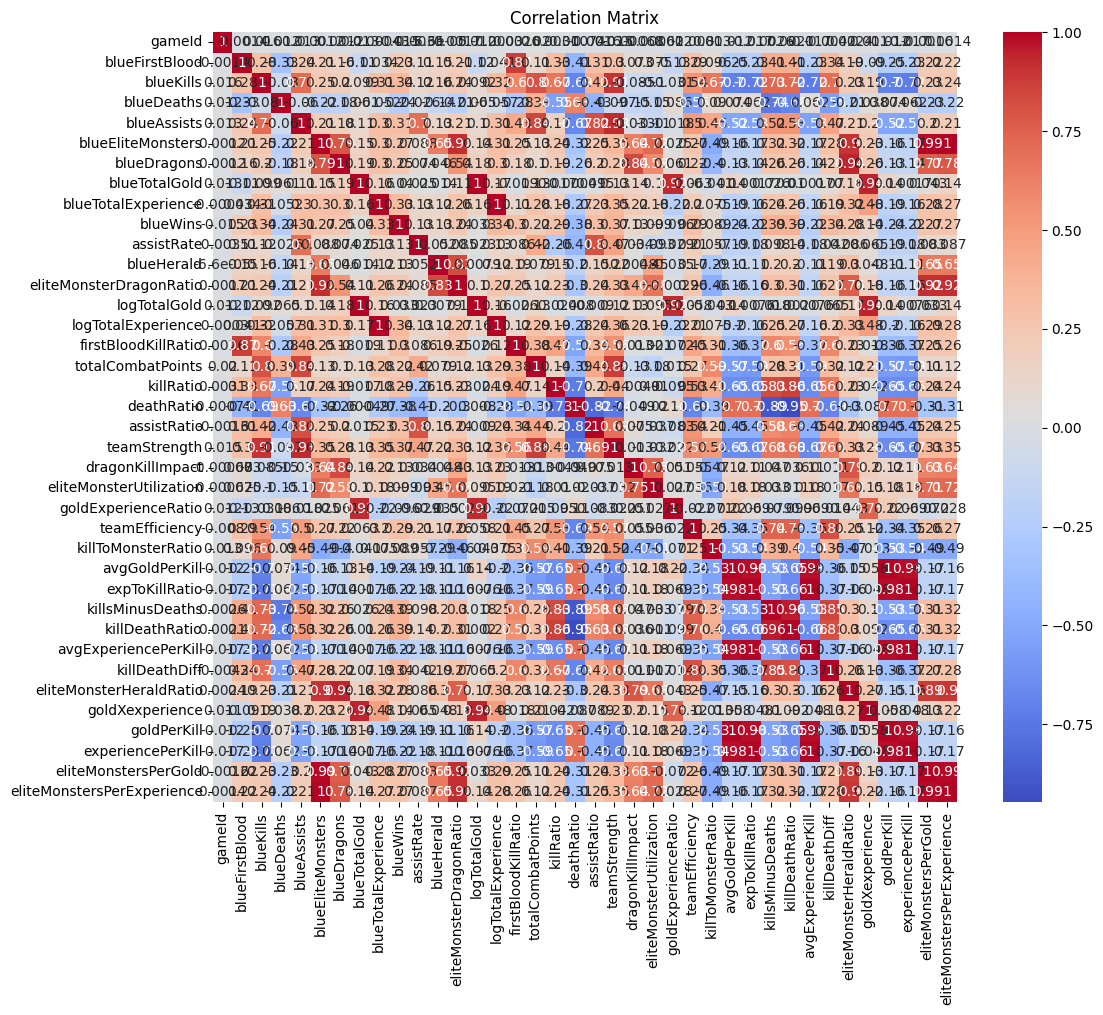

In [7]:
# 特徴量間の相関を観察
plt.figure(figsize=(12, 10))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# model

- data

In [8]:
# 無限値が含まれているセルをTrueとするブール型データフレームを作成
inf_df = train.replace([np.inf, -np.inf], np.nan).isna()

# 無限値を含む行と列のインデックスを取得
rows_with_inf = inf_df.any(axis=1)
cols_with_inf = inf_df.any(axis=0)

# 無限値を含む行と列のみを選択
inf_rows_cols_df = train.loc[rows_with_inf, cols_with_inf]

# 結果の表示
print(inf_rows_cols_df)

Empty DataFrame
Columns: []
Index: []


In [9]:
# データの準備
X = train.drop(['blueWins', 'gameId'], axis=1)
y = train['blueWins']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

# test_drop_gameId = test.drop('gameId', axis=1)

test_drop_gameId_temp = test.drop('gameId', axis=1)

# 特徴量の標準化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)  # 検証データも同じスケーラーを使用して標準化

# テストデータも同じスケーラーを使用して標準化
test_drop_gameId_scaled = scaler.transform(test_drop_gameId_temp)

# NumPy配列からPandasデータフレームに変換
X_train = pd.DataFrame(X_train, columns=X.columns)
X_val = pd.DataFrame(X_val, columns=X.columns)
test_drop_gameId = pd.DataFrame(test_drop_gameId_scaled, columns=test_drop_gameId_temp.columns)

- 特徴量選択

In [10]:
# RFECVで特徴量選択を行うためのモデルを定義（ここでは線形モデルの LogisticRegression を使用）
model = LogisticRegression(random_state=0)

# RFECVの設定
# cvはクロスバリデーションの分割数（例: 5分割）
# scoringはモデル評価の指標
rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(5), scoring='accuracy', min_features_to_select=10)

# RFECVをトレーニングデータに適用
rfecv.fit(X_train, y_train)

# 選択された特徴量の確認
print("選択された特徴量の数:", rfecv.n_features_)
selected_features = X_train.columns[rfecv.support_]
print("選択された特徴量:", selected_features)

# 選択された特徴量に基づいてデータセットを更新
X_train = X_train[selected_features]
X_val = X_val[selected_features]
test_drop_gameId = test_drop_gameId[selected_features]

c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

選択された特徴量の数: 15
選択された特徴量: Index(['blueEliteMonsters', 'blueTotalGold', 'blueTotalExperience',
       'logTotalGold', 'logTotalExperience', 'eliteMonsterUtilization',
       'goldExperienceRatio', 'avgGoldPerKill', 'expToKillRatio',
       'killDeathRatio', 'avgExperiencePerKill', 'goldXexperience',
       'goldPerKill', 'experiencePerKill', 'eliteMonstersPerExperience'],
      dtype='object')


c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

- 他model optuna無し

In [11]:
best_params_mlp = {'hidden_layer_sizes': (100,), 'alpha': 0.001}
best_params_svc = {'C': 1.0, 'kernel': 'rbf'}

- optuna_Lgbm

In [12]:
def objective(trial):
    # Optunaで調整するハイパーパラメータ
    param = {
        "objective": "binary",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "max_bin": trial.suggest_int("max_bin", 200, 400),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 0.9),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 0.9),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    # クロスバリデーションでのスコア計算
    kf = KFold(n_splits=3, shuffle=True, random_state=71)
    scores = []
    for tr_idx, va_idx in kf.split(X_train):
        tr_x, va_x = X_train.iloc[tr_idx], X_train.iloc[va_idx]
        tr_y, va_y = y_train.iloc[tr_idx], y_train.iloc[va_idx]

        lgb_train = lgb.Dataset(tr_x, tr_y)
        lgb_eval = lgb.Dataset(va_x, va_y, reference=lgb_train)

        callbacks = [lgb.early_stopping(100)]
        model = lgb.train(param, lgb_train, num_boost_round=5000, callbacks=callbacks, valid_sets=lgb_eval)
        preds = model.predict(va_x)
        pred_labels = np.rint(preds)
        score = accuracy_score(va_y, pred_labels)
        scores.append(score)

    return np.mean(scores)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# 最適なパラメータを取得
best_params_lgbm = study.best_params
print("Best params:", best_params_lgbm)

[I 2024-01-26 13:18:29,186] A new study created in memory with name: no-name-27fd8e3c-b9ff-43cc-8ec7-0bac7fe8ccdc


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[213]	valid_0's binary_logloss: 0.463365
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[182]	valid_0's binary_logloss: 0.47239
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:18:30,889] Trial 0 finished with value: 0.7778121962297003 and parameters: {'num_leaves': 166, 'max_bin': 255, 'learning_rate': 0.0132540960908535, 'bagging_fraction': 0.5872467599340895, 'bagging_freq': 4, 'feature_fraction': 0.5168455859579256, 'min_child_samples': 18}. Best is trial 0 with value: 0.7778121962297003.


Early stopping, best iteration is:
[215]	valid_0's binary_logloss: 0.469705
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[125]	valid_0's binary_logloss: 0.464864
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[102]	valid_0's binary_logloss: 0.472177
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:18:31,575] Trial 1 finished with value: 0.7715618785913274 and parameters: {'num_leaves': 74, 'max_bin': 383, 'learning_rate': 0.026888254391600454, 'bagging_fraction': 0.5664043333921902, 'bagging_freq': 6, 'feature_fraction': 0.8965560969835624, 'min_child_samples': 41}. Best is trial 0 with value: 0.7778121962297003.


Early stopping, best iteration is:
[150]	valid_0's binary_logloss: 0.471154
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.462561
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.474065
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.469786


[I 2024-01-26 13:18:32,217] Trial 2 finished with value: 0.7735937389467339 and parameters: {'num_leaves': 192, 'max_bin': 202, 'learning_rate': 0.0667580302968094, 'bagging_fraction': 0.8765685224413144, 'bagging_freq': 2, 'feature_fraction': 0.5158009069164855, 'min_child_samples': 29}. Best is trial 0 with value: 0.7778121962297003.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[235]	valid_0's binary_logloss: 0.458047
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[275]	valid_0's binary_logloss: 0.46927
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:18:33,123] Trial 3 finished with value: 0.7753114393899118 and parameters: {'num_leaves': 55, 'max_bin': 391, 'learning_rate': 0.021013180450456963, 'bagging_fraction': 0.4235022852121987, 'bagging_freq': 7, 'feature_fraction': 0.43186722951093665, 'min_child_samples': 46}. Best is trial 0 with value: 0.7778121962297003.


Early stopping, best iteration is:
[333]	valid_0's binary_logloss: 0.465388
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.461613
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.471276


[I 2024-01-26 13:18:33,777] Trial 4 finished with value: 0.7729679089677349 and parameters: {'num_leaves': 122, 'max_bin': 361, 'learning_rate': 0.07817442386549424, 'bagging_fraction': 0.42645697283263356, 'bagging_freq': 4, 'feature_fraction': 0.5470167183640793, 'min_child_samples': 27}. Best is trial 0 with value: 0.7778121962297003.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.472246
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[628]	valid_0's binary_logloss: 0.458004
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[571]	valid_0's binary_logloss: 0.466595
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:18:34,794] Trial 5 finished with value: 0.776248866204932 and parameters: {'num_leaves': 9, 'max_bin': 245, 'learning_rate': 0.015449652982082621, 'bagging_fraction': 0.7478702435551028, 'bagging_freq': 1, 'feature_fraction': 0.49198885779948226, 'min_child_samples': 12}. Best is trial 0 with value: 0.7778121962297003.


Early stopping, best iteration is:
[806]	valid_0's binary_logloss: 0.468443
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.460827
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:18:35,112] Trial 6 finished with value: 0.769998695028057 and parameters: {'num_leaves': 137, 'max_bin': 246, 'learning_rate': 0.09695957782337992, 'bagging_fraction': 0.518194065179717, 'bagging_freq': 1, 'feature_fraction': 0.7618841498629534, 'min_child_samples': 64}. Best is trial 0 with value: 0.7778121962297003.


Early stopping, best iteration is:
[54]	valid_0's binary_logloss: 0.473613
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.468213
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.461648
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.471279


[I 2024-01-26 13:18:35,546] Trial 7 finished with value: 0.7759366102921716 and parameters: {'num_leaves': 228, 'max_bin': 253, 'learning_rate': 0.08200775426069938, 'bagging_fraction': 0.5860514227422895, 'bagging_freq': 5, 'feature_fraction': 0.7105043791501792, 'min_child_samples': 53}. Best is trial 0 with value: 0.7778121962297003.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.46974
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	valid_0's binary_logloss: 0.460341
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	valid_0's binary_logloss: 0.468192
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:18:35,911] Trial 8 finished with value: 0.7726559459779696 and parameters: {'num_leaves': 92, 'max_bin': 312, 'learning_rate': 0.07409167496022655, 'bagging_fraction': 0.7144442934046624, 'bagging_freq': 5, 'feature_fraction': 0.44006933443585644, 'min_child_samples': 90}. Best is trial 0 with value: 0.7778121962297003.


Early stopping, best iteration is:
[102]	valid_0's binary_logloss: 0.467406
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.460825
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:18:36,248] Trial 9 finished with value: 0.7735927869469998 and parameters: {'num_leaves': 175, 'max_bin': 294, 'learning_rate': 0.09114233215740669, 'bagging_fraction': 0.8392608504531146, 'bagging_freq': 1, 'feature_fraction': 0.40274870106733374, 'min_child_samples': 70}. Best is trial 0 with value: 0.7778121962297003.


Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.470529
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[54]	valid_0's binary_logloss: 0.463857
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.479252
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.489981
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:18:37,996] Trial 10 finished with value: 0.7682818001231156 and parameters: {'num_leaves': 255, 'max_bin': 315, 'learning_rate': 0.04068009831063232, 'bagging_fraction': 0.6490058671645783, 'bagging_freq': 3, 'feature_fraction': 0.623636234992829, 'min_child_samples': 6}. Best is trial 0 with value: 0.7778121962297003.


Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.483397
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[4962]	valid_0's binary_logloss: 0.466377
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3678]	valid_0's binary_logloss: 0.477727
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[4962]	valid_0's binary_logloss: 0.478148


[I 2024-01-26 13:18:40,819] Trial 11 finished with value: 0.7648429573915676 and parameters: {'num_leaves': 2, 'max_bin': 238, 'learning_rate': 0.011347496656626559, 'bagging_fraction': 0.7349917801372222, 'bagging_freq': 3, 'feature_fraction': 0.5403374255806077, 'min_child_samples': 5}. Best is trial 0 with value: 0.7778121962297003.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[117]	valid_0's binary_logloss: 0.458949
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:18:41,283] Trial 12 finished with value: 0.7746864149491494 and parameters: {'num_leaves': 20, 'max_bin': 272, 'learning_rate': 0.0423992216017619, 'bagging_fraction': 0.766420082613216, 'bagging_freq': 3, 'feature_fraction': 0.5130300623324526, 'min_child_samples': 19}. Best is trial 0 with value: 0.7778121962297003.


Early stopping, best iteration is:
[101]	valid_0's binary_logloss: 0.467857
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[96]	valid_0's binary_logloss: 0.467294
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[245]	valid_0's binary_logloss: 0.463895
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[210]	valid_0's binary_logloss: 0.47426
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:18:43,027] Trial 13 finished with value: 0.7757811414125303 and parameters: {'num_leaves': 156, 'max_bin': 203, 'learning_rate': 0.011910778188039404, 'bagging_fraction': 0.6627809483174302, 'bagging_freq': 2, 'feature_fraction': 0.5998753917057841, 'min_child_samples': 21}. Best is trial 0 with value: 0.7778121962297003.


Early stopping, best iteration is:
[247]	valid_0's binary_logloss: 0.470998
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[84]	valid_0's binary_logloss: 0.466989
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[89]	valid_0's binary_logloss: 0.478576
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:18:44,192] Trial 14 finished with value: 0.7734378306825999 and parameters: {'num_leaves': 111, 'max_bin': 275, 'learning_rate': 0.030173624876421286, 'bagging_fraction': 0.814361771769023, 'bagging_freq': 7, 'feature_fraction': 0.4854512262393069, 'min_child_samples': 14}. Best is trial 0 with value: 0.7778121962297003.


Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.473397
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[56]	valid_0's binary_logloss: 0.460097
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.471977


[I 2024-01-26 13:18:44,810] Trial 15 finished with value: 0.7771869520966916 and parameters: {'num_leaves': 200, 'max_bin': 224, 'learning_rate': 0.05617859812560363, 'bagging_fraction': 0.7807702365459652, 'bagging_freq': 4, 'feature_fraction': 0.5923634152158502, 'min_child_samples': 38}. Best is trial 0 with value: 0.7778121962297003.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.468736
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.463507
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.474865
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.46807


[I 2024-01-26 13:18:45,532] Trial 16 finished with value: 0.7765614882714366 and parameters: {'num_leaves': 206, 'max_bin': 221, 'learning_rate': 0.06058074264873469, 'bagging_fraction': 0.7971172181832632, 'bagging_freq': 4, 'feature_fraction': 0.5708960907306214, 'min_child_samples': 34}. Best is trial 0 with value: 0.7778121962297003.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[77]	valid_0's binary_logloss: 0.461494
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[61]	valid_0's binary_logloss: 0.473714


[I 2024-01-26 13:18:46,280] Trial 17 finished with value: 0.7751559705102703 and parameters: {'num_leaves': 160, 'max_bin': 277, 'learning_rate': 0.049200873850645095, 'bagging_fraction': 0.8783755819199306, 'bagging_freq': 5, 'feature_fraction': 0.654103152595328, 'min_child_samples': 52}. Best is trial 0 with value: 0.7778121962297003.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[69]	valid_0's binary_logloss: 0.470527
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[114]	valid_0's binary_logloss: 0.457169
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[96]	valid_0's binary_logloss: 0.467805
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:18:46,880] Trial 18 finished with value: 0.773123817231869 and parameters: {'num_leaves': 217, 'max_bin': 336, 'learning_rate': 0.05757750071538035, 'bagging_fraction': 0.6770982169189917, 'bagging_freq': 4, 'feature_fraction': 0.5902991080125766, 'min_child_samples': 100}. Best is trial 0 with value: 0.7778121962297003.


Early stopping, best iteration is:
[145]	valid_0's binary_logloss: 0.464562
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[74]	valid_0's binary_logloss: 0.464269
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[83]	valid_0's binary_logloss: 0.474407
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:18:47,812] Trial 19 finished with value: 0.7756247937639037 and parameters: {'num_leaves': 256, 'max_bin': 224, 'learning_rate': 0.03653727052513069, 'bagging_fraction': 0.897483530626997, 'bagging_freq': 6, 'feature_fraction': 0.6668491222931907, 'min_child_samples': 38}. Best is trial 0 with value: 0.7778121962297003.


Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.47028
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[92]	valid_0's binary_logloss: 0.458228
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[121]	valid_0's binary_logloss: 0.46916


[I 2024-01-26 13:18:48,494] Trial 20 finished with value: 0.7746870007951395 and parameters: {'num_leaves': 183, 'max_bin': 262, 'learning_rate': 0.04974487954259656, 'bagging_fraction': 0.7874176687773252, 'bagging_freq': 4, 'feature_fraction': 0.46343804105991726, 'min_child_samples': 66}. Best is trial 0 with value: 0.7778121962297003.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[101]	valid_0's binary_logloss: 0.466622
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[51]	valid_0's binary_logloss: 0.462243
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.472508
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:18:49,276] Trial 21 finished with value: 0.7754683728845285 and parameters: {'num_leaves': 205, 'max_bin': 224, 'learning_rate': 0.06120449015613581, 'bagging_fraction': 0.811479061173936, 'bagging_freq': 4, 'feature_fraction': 0.5631526420913218, 'min_child_samples': 31}. Best is trial 0 with value: 0.7778121962297003.


Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.468418
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.460924
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.472394


[I 2024-01-26 13:18:49,908] Trial 22 finished with value: 0.7764055067765537 and parameters: {'num_leaves': 230, 'max_bin': 226, 'learning_rate': 0.06572788022757248, 'bagging_fraction': 0.716365162206605, 'bagging_freq': 5, 'feature_fraction': 0.5610176533557638, 'min_child_samples': 35}. Best is trial 0 with value: 0.7778121962297003.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.469531
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[51]	valid_0's binary_logloss: 0.462607
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[51]	valid_0's binary_logloss: 0.47527
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:18:51,022] Trial 23 finished with value: 0.7718746471193293 and parameters: {'num_leaves': 149, 'max_bin': 214, 'learning_rate': 0.05430492319761234, 'bagging_fraction': 0.7737666041317901, 'bagging_freq': 3, 'feature_fraction': 0.6065562321608037, 'min_child_samples': 24}. Best is trial 0 with value: 0.7778121962297003.


Early stopping, best iteration is:
[49]	valid_0's binary_logloss: 0.472013
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[70]	valid_0's binary_logloss: 0.459564
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[66]	valid_0's binary_logloss: 0.470877


[I 2024-01-26 13:18:51,689] Trial 24 finished with value: 0.7746869275643906 and parameters: {'num_leaves': 199, 'max_bin': 230, 'learning_rate': 0.05007161783229128, 'bagging_fraction': 0.8239819148664653, 'bagging_freq': 4, 'feature_fraction': 0.5117088545866795, 'min_child_samples': 44}. Best is trial 0 with value: 0.7778121962297003.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[64]	valid_0's binary_logloss: 0.466603
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[169]	valid_0's binary_logloss: 0.460406
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[114]	valid_0's binary_logloss: 0.471201
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:18:52,569] Trial 25 finished with value: 0.7729682751214787 and parameters: {'num_leaves': 174, 'max_bin': 261, 'learning_rate': 0.03117258361451065, 'bagging_fraction': 0.6990792471375904, 'bagging_freq': 6, 'feature_fraction': 0.5691916756148909, 'min_child_samples': 55}. Best is trial 0 with value: 0.7778121962297003.


Early stopping, best iteration is:
[152]	valid_0's binary_logloss: 0.470074
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[117]	valid_0's binary_logloss: 0.465233
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[114]	valid_0's binary_logloss: 0.473658
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:18:54,006] Trial 26 finished with value: 0.7759370496766641 and parameters: {'num_leaves': 224, 'max_bin': 290, 'learning_rate': 0.022009281758518573, 'bagging_fraction': 0.6284066022836767, 'bagging_freq': 2, 'feature_fraction': 0.46690718352078875, 'min_child_samples': 16}. Best is trial 0 with value: 0.7778121962297003.


Early stopping, best iteration is:
[117]	valid_0's binary_logloss: 0.471109
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[64]	valid_0's binary_logloss: 0.463008
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[70]	valid_0's binary_logloss: 0.473388
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:18:54,939] Trial 27 finished with value: 0.7735930798699949 and parameters: {'num_leaves': 208, 'max_bin': 211, 'learning_rate': 0.04411930079298545, 'bagging_fraction': 0.7486197925411813, 'bagging_freq': 5, 'feature_fraction': 0.6350018857519322, 'min_child_samples': 34}. Best is trial 0 with value: 0.7778121962297003.


Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.470404
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[102]	valid_0's binary_logloss: 0.461184
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[97]	valid_0's binary_logloss: 0.47012
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:18:55,721] Trial 28 finished with value: 0.7756251599176477 and parameters: {'num_leaves': 240, 'max_bin': 242, 'learning_rate': 0.036189200576722064, 'bagging_fraction': 0.7887828854330599, 'bagging_freq': 3, 'feature_fraction': 0.5269484739389453, 'min_child_samples': 46}. Best is trial 0 with value: 0.7778121962297003.


Early stopping, best iteration is:
[110]	valid_0's binary_logloss: 0.468047
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[61]	valid_0's binary_logloss: 0.460578
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.470397


[I 2024-01-26 13:18:56,303] Trial 29 finished with value: 0.7764055800073025 and parameters: {'num_leaves': 170, 'max_bin': 217, 'learning_rate': 0.05887921469480638, 'bagging_fraction': 0.5994974691475955, 'bagging_freq': 4, 'feature_fraction': 0.5825722495552852, 'min_child_samples': 40}. Best is trial 0 with value: 0.7778121962297003.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.466255
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.466656
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.47745
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:18:57,103] Trial 30 finished with value: 0.7734376842211024 and parameters: {'num_leaves': 134, 'max_bin': 260, 'learning_rate': 0.06729549291653976, 'bagging_fraction': 0.6903447509458209, 'bagging_freq': 6, 'feature_fraction': 0.6703499206312236, 'min_child_samples': 25}. Best is trial 0 with value: 0.7778121962297003.


Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.472142
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.460758
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.470109
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:18:57,636] Trial 31 finished with value: 0.7757809217202839 and parameters: {'num_leaves': 167, 'max_bin': 218, 'learning_rate': 0.05552938225240624, 'bagging_fraction': 0.5963063569868119, 'bagging_freq': 4, 'feature_fraction': 0.569853535987746, 'min_child_samples': 38}. Best is trial 0 with value: 0.7778121962297003.


Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.467456
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.459538
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.469476


[I 2024-01-26 13:18:58,221] Trial 32 finished with value: 0.7731251353853468 and parameters: {'num_leaves': 192, 'max_bin': 240, 'learning_rate': 0.06175025630343618, 'bagging_fraction': 0.6322681993015424, 'bagging_freq': 4, 'feature_fraction': 0.5928732455210936, 'min_child_samples': 41}. Best is trial 0 with value: 0.7778121962297003.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[61]	valid_0's binary_logloss: 0.468452
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.460104
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:18:58,768] Trial 33 finished with value: 0.776249525281671 and parameters: {'num_leaves': 187, 'max_bin': 200, 'learning_rate': 0.06880247371986242, 'bagging_fraction': 0.5294192202123778, 'bagging_freq': 5, 'feature_fraction': 0.523129699626536, 'min_child_samples': 30}. Best is trial 0 with value: 0.7778121962297003.


Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.472011
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[47]	valid_0's binary_logloss: 0.470224
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.461019
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[56]	valid_0's binary_logloss: 0.471622
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:18:59,453] Trial 34 finished with value: 0.7760926650178032 and parameters: {'num_leaves': 109, 'max_bin': 211, 'learning_rate': 0.06013782993715606, 'bagging_fraction': 0.8458644823971023, 'bagging_freq': 3, 'feature_fraction': 0.6168653795860067, 'min_child_samples': 48}. Best is trial 0 with value: 0.7778121962297003.


Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.467784
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[180]	valid_0's binary_logloss: 0.459916
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[256]	valid_0's binary_logloss: 0.46874
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:19:00,352] Trial 35 finished with value: 0.7737492810571238 and parameters: {'num_leaves': 145, 'max_bin': 232, 'learning_rate': 0.023202738049069936, 'bagging_fraction': 0.551061068250013, 'bagging_freq': 4, 'feature_fraction': 0.5383067177995228, 'min_child_samples': 61}. Best is trial 0 with value: 0.7778121962297003.


Early stopping, best iteration is:
[217]	valid_0's binary_logloss: 0.465119
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.45989
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[61]	valid_0's binary_logloss: 0.469803


[I 2024-01-26 13:19:01,000] Trial 36 finished with value: 0.7768742567994383 and parameters: {'num_leaves': 210, 'max_bin': 374, 'learning_rate': 0.05347716442579913, 'bagging_fraction': 0.6049406522748759, 'bagging_freq': 5, 'feature_fraction': 0.48389820762646024, 'min_child_samples': 29}. Best is trial 0 with value: 0.7778121962297003.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.469524
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 0.467588
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[151]	valid_0's binary_logloss: 0.474453
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:19:02,868] Trial 37 finished with value: 0.7732814830339733 and parameters: {'num_leaves': 213, 'max_bin': 371, 'learning_rate': 0.016241023779691444, 'bagging_fraction': 0.4758666555410608, 'bagging_freq': 5, 'feature_fraction': 0.49278953204476866, 'min_child_samples': 10}. Best is trial 0 with value: 0.7778121962297003.


Early stopping, best iteration is:
[156]	valid_0's binary_logloss: 0.469106
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[122]	valid_0's binary_logloss: 0.461932
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[115]	valid_0's binary_logloss: 0.4704
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:19:03,823] Trial 38 finished with value: 0.7756249402254013 and parameters: {'num_leaves': 234, 'max_bin': 344, 'learning_rate': 0.02776756790742416, 'bagging_fraction': 0.5690269395359592, 'bagging_freq': 7, 'feature_fraction': 0.5516270603238382, 'min_child_samples': 28}. Best is trial 0 with value: 0.7778121962297003.


Early stopping, best iteration is:
[104]	valid_0's binary_logloss: 0.468272
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.466828
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.474216
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:19:04,668] Trial 39 finished with value: 0.7720315073831973 and parameters: {'num_leaves': 198, 'max_bin': 398, 'learning_rate': 0.07420345993141109, 'bagging_fraction': 0.609604028356439, 'bagging_freq': 6, 'feature_fraction': 0.4383849184706933, 'min_child_samples': 19}. Best is trial 0 with value: 0.7778121962297003.


Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.47035
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[305]	valid_0's binary_logloss: 0.457658
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[288]	valid_0's binary_logloss: 0.469643
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:19:05,880] Trial 40 finished with value: 0.771248963601828 and parameters: {'num_leaves': 243, 'max_bin': 333, 'learning_rate': 0.01880905759441691, 'bagging_fraction': 0.6543504891271643, 'bagging_freq': 5, 'feature_fraction': 0.49101313594441554, 'min_child_samples': 75}. Best is trial 0 with value: 0.7778121962297003.


Early stopping, best iteration is:
[385]	valid_0's binary_logloss: 0.465183
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	valid_0's binary_logloss: 0.46092
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.471089
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.468207


[I 2024-01-26 13:19:06,550] Trial 41 finished with value: 0.7796871230904898 and parameters: {'num_leaves': 183, 'max_bin': 386, 'learning_rate': 0.052646974714064106, 'bagging_fraction': 0.6138603378249364, 'bagging_freq': 4, 'feature_fraction': 0.5357040192343793, 'min_child_samples': 33}. Best is trial 41 with value: 0.7796871230904898.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[61]	valid_0's binary_logloss: 0.459015
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.471931
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.469055


[I 2024-01-26 13:19:07,164] Trial 42 finished with value: 0.7784367080552212 and parameters: {'num_leaves': 182, 'max_bin': 371, 'learning_rate': 0.04797515983400556, 'bagging_fraction': 0.6247555471776602, 'bagging_freq': 4, 'feature_fraction': 0.5293163630788228, 'min_child_samples': 33}. Best is trial 41 with value: 0.7796871230904898.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[56]	valid_0's binary_logloss: 0.461167
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[61]	valid_0's binary_logloss: 0.472734
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:19:07,966] Trial 43 finished with value: 0.7773436658990619 and parameters: {'num_leaves': 182, 'max_bin': 381, 'learning_rate': 0.04596875307072183, 'bagging_fraction': 0.6224836281040933, 'bagging_freq': 5, 'feature_fraction': 0.5120763384371194, 'min_child_samples': 24}. Best is trial 41 with value: 0.7796871230904898.


Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.469666
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.462572
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.472503
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:19:08,947] Trial 44 finished with value: 0.7764058729302977 and parameters: {'num_leaves': 182, 'max_bin': 386, 'learning_rate': 0.04526075957609656, 'bagging_fraction': 0.6246460570932661, 'bagging_freq': 3, 'feature_fraction': 0.542621819686009, 'min_child_samples': 23}. Best is trial 41 with value: 0.7796871230904898.


Early stopping, best iteration is:
[54]	valid_0's binary_logloss: 0.470007
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.471459
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.476417
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:19:10,127] Trial 45 finished with value: 0.7696879037302717 and parameters: {'num_leaves': 128, 'max_bin': 358, 'learning_rate': 0.039249969604308564, 'bagging_fraction': 0.6502056007694635, 'bagging_freq': 3, 'feature_fraction': 0.5167367063475167, 'min_child_samples': 12}. Best is trial 41 with value: 0.7796871230904898.


Early stopping, best iteration is:
[56]	valid_0's binary_logloss: 0.473199
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.463547
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[64]	valid_0's binary_logloss: 0.472552
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:19:10,984] Trial 46 finished with value: 0.7751553114335316 and parameters: {'num_leaves': 154, 'max_bin': 376, 'learning_rate': 0.046430757039684044, 'bagging_fraction': 0.5706731240787402, 'bagging_freq': 4, 'feature_fraction': 0.5425781482204849, 'min_child_samples': 17}. Best is trial 41 with value: 0.7796871230904898.


Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.470791
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[97]	valid_0's binary_logloss: 0.460501
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.468348
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:19:11,750] Trial 47 finished with value: 0.7751561169717679 and parameters: {'num_leaves': 54, 'max_bin': 357, 'learning_rate': 0.03422861407250006, 'bagging_fraction': 0.5808454162346489, 'bagging_freq': 5, 'feature_fraction': 0.4055372458288892, 'min_child_samples': 33}. Best is trial 41 with value: 0.7796871230904898.


Early stopping, best iteration is:
[101]	valid_0's binary_logloss: 0.466373
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[66]	valid_0's binary_logloss: 0.462121
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[67]	valid_0's binary_logloss: 0.470616
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:19:12,611] Trial 48 finished with value: 0.7770313367555527 and parameters: {'num_leaves': 142, 'max_bin': 388, 'learning_rate': 0.03989720758262824, 'bagging_fraction': 0.6699065122444139, 'bagging_freq': 2, 'feature_fraction': 0.5089022309191518, 'min_child_samples': 26}. Best is trial 41 with value: 0.7796871230904898.


Early stopping, best iteration is:
[77]	valid_0's binary_logloss: 0.469658
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.473429
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[96]	valid_0's binary_logloss: 0.483171
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:19:14,593] Trial 49 finished with value: 0.7679683725183747 and parameters: {'num_leaves': 161, 'max_bin': 400, 'learning_rate': 0.02548417731309894, 'bagging_fraction': 0.6372452457965218, 'bagging_freq': 4, 'feature_fraction': 0.4655816677881385, 'min_child_samples': 8}. Best is trial 41 with value: 0.7796871230904898.


Early stopping, best iteration is:
[81]	valid_0's binary_logloss: 0.478086
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[426]	valid_0's binary_logloss: 0.460347
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[332]	valid_0's binary_logloss: 0.470799
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:19:15,993] Trial 50 finished with value: 0.7720304089219657 and parameters: {'num_leaves': 180, 'max_bin': 321, 'learning_rate': 0.01016756321599873, 'bagging_fraction': 0.5550389341402953, 'bagging_freq': 5, 'feature_fraction': 0.5939216230908432, 'min_child_samples': 49}. Best is trial 41 with value: 0.7796871230904898.


Early stopping, best iteration is:
[440]	valid_0's binary_logloss: 0.466419
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[66]	valid_0's binary_logloss: 0.461631
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[67]	valid_0's binary_logloss: 0.469887
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:19:16,864] Trial 51 finished with value: 0.775624720533155 and parameters: {'num_leaves': 112, 'max_bin': 388, 'learning_rate': 0.04192107869252422, 'bagging_fraction': 0.6809830253168963, 'bagging_freq': 2, 'feature_fraction': 0.5137433834539392, 'min_child_samples': 26}. Best is trial 41 with value: 0.7796871230904898.


Early stopping, best iteration is:
[70]	valid_0's binary_logloss: 0.468647
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	valid_0's binary_logloss: 0.463386
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	valid_0's binary_logloss: 0.471173
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:19:17,708] Trial 52 finished with value: 0.7729687145059715 and parameters: {'num_leaves': 143, 'max_bin': 366, 'learning_rate': 0.05219916036527331, 'bagging_fraction': 0.6158932075964325, 'bagging_freq': 2, 'feature_fraction': 0.5339239893932227, 'min_child_samples': 20}. Best is trial 41 with value: 0.7796871230904898.


Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.469249
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.462173
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	valid_0's binary_logloss: 0.472789
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:19:18,485] Trial 53 finished with value: 0.7760933240945421 and parameters: {'num_leaves': 193, 'max_bin': 381, 'learning_rate': 0.04693029198932411, 'bagging_fraction': 0.6705762557440013, 'bagging_freq': 1, 'feature_fraction': 0.500536671912195, 'min_child_samples': 23}. Best is trial 41 with value: 0.7796871230904898.


Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.468439
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[93]	valid_0's binary_logloss: 0.461667
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.47193
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[113]	valid_0's binary_logloss: 0.469932


[I 2024-01-26 13:19:19,408] Trial 54 finished with value: 0.7750003551691315 and parameters: {'num_leaves': 169, 'max_bin': 351, 'learning_rate': 0.039174912012616275, 'bagging_fraction': 0.6564891005483044, 'bagging_freq': 3, 'feature_fraction': 0.550361269781338, 'min_child_samples': 36}. Best is trial 41 with value: 0.7796871230904898.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.461091
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	valid_0's binary_logloss: 0.470977
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:19:20,056] Trial 55 finished with value: 0.7770304579865673 and parameters: {'num_leaves': 118, 'max_bin': 390, 'learning_rate': 0.049095694266412956, 'bagging_fraction': 0.5959065107800433, 'bagging_freq': 4, 'feature_fraction': 0.5012318812059176, 'min_child_samples': 42}. Best is trial 41 with value: 0.7796871230904898.


Early stopping, best iteration is:
[104]	valid_0's binary_logloss: 0.468749
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[64]	valid_0's binary_logloss: 0.461703
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[66]	valid_0's binary_logloss: 0.472328
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:19:20,885] Trial 56 finished with value: 0.7753118787744043 and parameters: {'num_leaves': 161, 'max_bin': 379, 'learning_rate': 0.04347213969134804, 'bagging_fraction': 0.7108947993897882, 'bagging_freq': 1, 'feature_fraction': 0.5797268682629549, 'min_child_samples': 30}. Best is trial 41 with value: 0.7796871230904898.


Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.469534
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.462772
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.475708
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:19:21,689] Trial 57 finished with value: 0.7748434216745149 and parameters: {'num_leaves': 90, 'max_bin': 393, 'learning_rate': 0.055622062756030884, 'bagging_fraction': 0.636384143837685, 'bagging_freq': 2, 'feature_fraction': 0.4755435062448532, 'min_child_samples': 16}. Best is trial 41 with value: 0.7796871230904898.


Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.470068
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.468179
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.476248
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:19:22,836] Trial 58 finished with value: 0.7745310193002567 and parameters: {'num_leaves': 176, 'max_bin': 366, 'learning_rate': 0.051949837307246706, 'bagging_fraction': 0.6680426116374346, 'bagging_freq': 4, 'feature_fraction': 0.44740568712134515, 'min_child_samples': 13}. Best is trial 41 with value: 0.7796871230904898.


Early stopping, best iteration is:
[54]	valid_0's binary_logloss: 0.474372
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[85]	valid_0's binary_logloss: 0.461938
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[98]	valid_0's binary_logloss: 0.470226
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:19:23,726] Trial 59 finished with value: 0.7757811414125303 and parameters: {'num_leaves': 220, 'max_bin': 286, 'learning_rate': 0.03315970407910739, 'bagging_fraction': 0.6886784609943566, 'bagging_freq': 3, 'feature_fraction': 0.5238644539856678, 'min_child_samples': 32}. Best is trial 41 with value: 0.7796871230904898.


Early stopping, best iteration is:
[104]	valid_0's binary_logloss: 0.467776
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[70]	valid_0's binary_logloss: 0.460706
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[77]	valid_0's binary_logloss: 0.473756
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:19:24,571] Trial 60 finished with value: 0.7749997693231414 and parameters: {'num_leaves': 140, 'max_bin': 297, 'learning_rate': 0.039583081614570505, 'bagging_fraction': 0.7342060789907705, 'bagging_freq': 4, 'feature_fraction': 0.5617620975627042, 'min_child_samples': 27}. Best is trial 41 with value: 0.7796871230904898.


Early stopping, best iteration is:
[62]	valid_0's binary_logloss: 0.469192
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.463311
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[70]	valid_0's binary_logloss: 0.470507
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:19:25,104] Trial 61 finished with value: 0.775155750818024 and parameters: {'num_leaves': 119, 'max_bin': 394, 'learning_rate': 0.04778730416871876, 'bagging_fraction': 0.5946007619863765, 'bagging_freq': 4, 'feature_fraction': 0.5012843234289555, 'min_child_samples': 43}. Best is trial 41 with value: 0.7796871230904898.


Early stopping, best iteration is:
[70]	valid_0's binary_logloss: 0.468944
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[64]	valid_0's binary_logloss: 0.460665
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.470501
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:19:25,754] Trial 62 finished with value: 0.7753120252359018 and parameters: {'num_leaves': 97, 'max_bin': 383, 'learning_rate': 0.04873153402691182, 'bagging_fraction': 0.6126562164289411, 'bagging_freq': 4, 'feature_fraction': 0.5113911021593427, 'min_child_samples': 41}. Best is trial 41 with value: 0.7796871230904898.


Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.468824
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[74]	valid_0's binary_logloss: 0.460892
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.470185
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:19:26,337] Trial 63 finished with value: 0.7781244521424607 and parameters: {'num_leaves': 126, 'max_bin': 389, 'learning_rate': 0.05047814424513677, 'bagging_fraction': 0.588577717349986, 'bagging_freq': 4, 'feature_fraction': 0.4984892064400309, 'min_child_samples': 37}. Best is trial 41 with value: 0.7796871230904898.


Early stopping, best iteration is:
[71]	valid_0's binary_logloss: 0.467632
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[88]	valid_0's binary_logloss: 0.45946
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[98]	valid_0's binary_logloss: 0.469371


[I 2024-01-26 13:19:27,018] Trial 64 finished with value: 0.7765625135019194 and parameters: {'num_leaves': 151, 'max_bin': 366, 'learning_rate': 0.04424339050910034, 'bagging_fraction': 0.6200925647360224, 'bagging_freq': 3, 'feature_fraction': 0.4819872142306954, 'min_child_samples': 36}. Best is trial 41 with value: 0.7796871230904898.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[77]	valid_0's binary_logloss: 0.46698
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.462668
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[71]	valid_0's binary_logloss: 0.470187
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[85]	valid_0's binary_logloss: 0.469209


[I 2024-01-26 13:19:27,737] Trial 65 finished with value: 0.7743741590363888 and parameters: {'num_leaves': 200, 'max_bin': 312, 'learning_rate': 0.05180467702234126, 'bagging_fraction': 0.5820279087894041, 'bagging_freq': 5, 'feature_fraction': 0.5349651866708531, 'min_child_samples': 38}. Best is trial 41 with value: 0.7796871230904898.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.464213
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[51]	valid_0's binary_logloss: 0.472422
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:19:28,517] Trial 66 finished with value: 0.7739065807054845 and parameters: {'num_leaves': 130, 'max_bin': 254, 'learning_rate': 0.05659840207061058, 'bagging_fraction': 0.6540546930101384, 'bagging_freq': 4, 'feature_fraction': 0.5526983495583212, 'min_child_samples': 22}. Best is trial 41 with value: 0.7796871230904898.


Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.469564
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.459731
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	valid_0's binary_logloss: 0.470264


[I 2024-01-26 13:19:29,134] Trial 67 finished with value: 0.7774992812402007 and parameters: {'num_leaves': 166, 'max_bin': 370, 'learning_rate': 0.057514190842231465, 'bagging_fraction': 0.6367879101101962, 'bagging_freq': 5, 'feature_fraction': 0.4564136814543368, 'min_child_samples': 32}. Best is trial 41 with value: 0.7796871230904898.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[64]	valid_0's binary_logloss: 0.46816
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[72]	valid_0's binary_logloss: 0.459794
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[71]	valid_0's binary_logloss: 0.467615
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:19:29,752] Trial 68 finished with value: 0.7751555311257778 and parameters: {'num_leaves': 190, 'max_bin': 371, 'learning_rate': 0.06256851863006418, 'bagging_fraction': 0.6419148570351743, 'bagging_freq': 5, 'feature_fraction': 0.4747428769625967, 'min_child_samples': 57}. Best is trial 41 with value: 0.7796871230904898.


Early stopping, best iteration is:
[75]	valid_0's binary_logloss: 0.468364
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.460065
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[72]	valid_0's binary_logloss: 0.468524
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:19:30,270] Trial 69 finished with value: 0.7765620008866779 and parameters: {'num_leaves': 169, 'max_bin': 350, 'learning_rate': 0.057363350482212166, 'bagging_fraction': 0.6279946131949273, 'bagging_freq': 6, 'feature_fraction': 0.4503536854375235, 'min_child_samples': 46}. Best is trial 41 with value: 0.7796871230904898.


Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.466188
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.459909
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[56]	valid_0's binary_logloss: 0.471988
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:19:30,945] Trial 70 finished with value: 0.7737494275186215 and parameters: {'num_leaves': 181, 'max_bin': 268, 'learning_rate': 0.05843723919635438, 'bagging_fraction': 0.5902607966983314, 'bagging_freq': 4, 'feature_fraction': 0.45751512417838464, 'min_child_samples': 32}. Best is trial 41 with value: 0.7796871230904898.


Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.467697
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.463445
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[61]	valid_0's binary_logloss: 0.468336
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:19:31,702] Trial 71 finished with value: 0.774844007520505 and parameters: {'num_leaves': 158, 'max_bin': 384, 'learning_rate': 0.05148532464248304, 'bagging_fraction': 0.6095050902125215, 'bagging_freq': 5, 'feature_fraction': 0.5262324625134103, 'min_child_samples': 25}. Best is trial 41 with value: 0.7796871230904898.


Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.471395
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.461475
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	valid_0's binary_logloss: 0.472882


[I 2024-01-26 13:19:32,435] Trial 72 finished with value: 0.7767182753045557 and parameters: {'num_leaves': 163, 'max_bin': 377, 'learning_rate': 0.054342049400026196, 'bagging_fraction': 0.6665266153935568, 'bagging_freq': 5, 'feature_fraction': 0.5000725976655767, 'min_child_samples': 28}. Best is trial 41 with value: 0.7796871230904898.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.47115
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[74]	valid_0's binary_logloss: 0.458987
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:19:33,065] Trial 73 finished with value: 0.7756245008409087 and parameters: {'num_leaves': 149, 'max_bin': 396, 'learning_rate': 0.042792914511992325, 'bagging_fraction': 0.6436446611265826, 'bagging_freq': 4, 'feature_fraction': 0.42999586443789845, 'min_child_samples': 38}. Best is trial 41 with value: 0.7796871230904898.


Early stopping, best iteration is:
[75]	valid_0's binary_logloss: 0.471533
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[85]	valid_0's binary_logloss: 0.466668
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[51]	valid_0's binary_logloss: 0.463392
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	valid_0's binary_logloss: 0.476479
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:19:33,963] Trial 74 finished with value: 0.7728117810113547 and parameters: {'num_leaves': 174, 'max_bin': 305, 'learning_rate': 0.04906249980435439, 'bagging_fraction': 0.6227924074307729, 'bagging_freq': 5, 'feature_fraction': 0.5818483255197219, 'min_child_samples': 18}. Best is trial 41 with value: 0.7796871230904898.


Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.475806
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[66]	valid_0's binary_logloss: 0.460843
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.471205
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:19:35,030] Trial 75 finished with value: 0.7745308728387593 and parameters: {'num_leaves': 136, 'max_bin': 389, 'learning_rate': 0.04658688825555315, 'bagging_fraction': 0.6777879012791105, 'bagging_freq': 3, 'feature_fraction': 0.4855348701237263, 'min_child_samples': 31}. Best is trial 41 with value: 0.7796871230904898.


Early stopping, best iteration is:
[64]	valid_0's binary_logloss: 0.467438
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.461537
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.467384
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:19:35,667] Trial 76 finished with value: 0.777030238294321 and parameters: {'num_leaves': 191, 'max_bin': 360, 'learning_rate': 0.06384175518679332, 'bagging_fraction': 0.5805064245904658, 'bagging_freq': 7, 'feature_fraction': 0.5142644830012664, 'min_child_samples': 35}. Best is trial 41 with value: 0.7796871230904898.


Early stopping, best iteration is:
[60]	valid_0's binary_logloss: 0.469172
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[146]	valid_0's binary_logloss: 0.46028
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[161]	valid_0's binary_logloss: 0.467722
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:19:36,315] Trial 77 finished with value: 0.7743740125748912 and parameters: {'num_leaves': 200, 'max_bin': 371, 'learning_rate': 0.054346869767816185, 'bagging_fraction': 0.5501443949117351, 'bagging_freq': 6, 'feature_fraction': 0.47527237300540137, 'min_child_samples': 84}. Best is trial 41 with value: 0.7796871230904898.


Early stopping, best iteration is:
[106]	valid_0's binary_logloss: 0.465641
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[365]	valid_0's binary_logloss: 0.458542
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[311]	valid_0's binary_logloss: 0.468683
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:19:37,648] Trial 78 finished with value: 0.7740622692773721 and parameters: {'num_leaves': 177, 'max_bin': 400, 'learning_rate': 0.013331618185344205, 'bagging_fraction': 0.6021724770026, 'bagging_freq': 4, 'feature_fraction': 0.558210591590224, 'min_child_samples': 50}. Best is trial 41 with value: 0.7796871230904898.


Early stopping, best iteration is:
[349]	valid_0's binary_logloss: 0.465869
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.464134
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.473112
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:19:38,595] Trial 79 finished with value: 0.7757811414125303 and parameters: {'num_leaves': 128, 'max_bin': 337, 'learning_rate': 0.060271125345434856, 'bagging_fraction': 0.6411380526423514, 'bagging_freq': 4, 'feature_fraction': 0.5322055573540171, 'min_child_samples': 21}. Best is trial 41 with value: 0.7796871230904898.


Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.470239
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.465325
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.473305
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:19:39,463] Trial 80 finished with value: 0.7768749158761774 and parameters: {'num_leaves': 214, 'max_bin': 249, 'learning_rate': 0.03697584383010031, 'bagging_fraction': 0.6967531072491651, 'bagging_freq': 6, 'feature_fraction': 0.5729850552776568, 'min_child_samples': 25}. Best is trial 41 with value: 0.7796871230904898.


Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.470753
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.462147
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	valid_0's binary_logloss: 0.472555
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:19:40,028] Trial 81 finished with value: 0.7760931044022957 and parameters: {'num_leaves': 103, 'max_bin': 388, 'learning_rate': 0.04938731795818943, 'bagging_fraction': 0.5973913753313467, 'bagging_freq': 4, 'feature_fraction': 0.5035404257945489, 'min_child_samples': 38}. Best is trial 41 with value: 0.7796871230904898.


Early stopping, best iteration is:
[66]	valid_0's binary_logloss: 0.467835
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[74]	valid_0's binary_logloss: 0.459796
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.470603
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:19:40,641] Trial 82 finished with value: 0.7756243543794111 and parameters: {'num_leaves': 187, 'max_bin': 392, 'learning_rate': 0.051422029252441874, 'bagging_fraction': 0.6165328109513347, 'bagging_freq': 4, 'feature_fraction': 0.49584353544125165, 'min_child_samples': 43}. Best is trial 41 with value: 0.7796871230904898.


Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.466809
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[72]	valid_0's binary_logloss: 0.462287
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:19:41,350] Trial 83 finished with value: 0.7785927627808528 and parameters: {'num_leaves': 119, 'max_bin': 380, 'learning_rate': 0.04550003033024556, 'bagging_fraction': 0.5883835232752893, 'bagging_freq': 4, 'feature_fraction': 0.5215539996433853, 'min_child_samples': 34}. Best is trial 41 with value: 0.7796871230904898.


Early stopping, best iteration is:
[67]	valid_0's binary_logloss: 0.472271
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.469142
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[61]	valid_0's binary_logloss: 0.462038
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[74]	valid_0's binary_logloss: 0.472476
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:19:42,111] Trial 84 finished with value: 0.7754686658075235 and parameters: {'num_leaves': 166, 'max_bin': 379, 'learning_rate': 0.045631205747206985, 'bagging_fraction': 0.6285030019976554, 'bagging_freq': 4, 'feature_fraction': 0.5274633907208757, 'min_child_samples': 28}. Best is trial 41 with value: 0.7796871230904898.


Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.470378
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[95]	valid_0's binary_logloss: 0.460587
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[85]	valid_0's binary_logloss: 0.47111
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:19:42,996] Trial 85 finished with value: 0.7748432019822685 and parameters: {'num_leaves': 144, 'max_bin': 373, 'learning_rate': 0.041567439189589474, 'bagging_fraction': 0.579467200292365, 'bagging_freq': 5, 'feature_fraction': 0.5474742112102022, 'min_child_samples': 33}. Best is trial 41 with value: 0.7796871230904898.


Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.469031
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.459593
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.469858
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:19:43,594] Trial 86 finished with value: 0.7734370251443634 and parameters: {'num_leaves': 124, 'max_bin': 282, 'learning_rate': 0.053557185191706144, 'bagging_fraction': 0.5657396934564356, 'bagging_freq': 5, 'feature_fraction': 0.5134072887513506, 'min_child_samples': 35}. Best is trial 41 with value: 0.7796871230904898.


Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.468656
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.461674
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	valid_0's binary_logloss: 0.470211
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:19:44,259] Trial 87 finished with value: 0.774842762597776 and parameters: {'num_leaves': 204, 'max_bin': 364, 'learning_rate': 0.0569798757586478, 'bagging_fraction': 0.6075835630568862, 'bagging_freq': 3, 'feature_fraction': 0.489460992475683, 'min_child_samples': 30}. Best is trial 41 with value: 0.7796871230904898.


Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.467256
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[115]	valid_0's binary_logloss: 0.460652
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[120]	valid_0's binary_logloss: 0.471502
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:19:45,198] Trial 88 finished with value: 0.7739052625520065 and parameters: {'num_leaves': 67, 'max_bin': 235, 'learning_rate': 0.028265163066181122, 'bagging_fraction': 0.6509548391256085, 'bagging_freq': 1, 'feature_fraction': 0.6036837088691733, 'min_child_samples': 39}. Best is trial 41 with value: 0.7796871230904898.


Early stopping, best iteration is:
[125]	valid_0's binary_logloss: 0.468983
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[56]	valid_0's binary_logloss: 0.461473
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.475008
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:19:45,959] Trial 89 finished with value: 0.7715615856683323 and parameters: {'num_leaves': 87, 'max_bin': 384, 'learning_rate': 0.04499031067694954, 'bagging_fraction': 0.6268346325724292, 'bagging_freq': 4, 'feature_fraction': 0.5626449644857925, 'min_child_samples': 15}. Best is trial 41 with value: 0.7796871230904898.


Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.471449
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.46186
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[49]	valid_0's binary_logloss: 0.473034
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:19:47,010] Trial 90 finished with value: 0.7740625622003673 and parameters: {'num_leaves': 113, 'max_bin': 352, 'learning_rate': 0.05913553866736215, 'bagging_fraction': 0.6645900262273851, 'bagging_freq': 4, 'feature_fraction': 0.5425737417081228, 'min_child_samples': 23}. Best is trial 41 with value: 0.7796871230904898.


Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.469993
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[64]	valid_0's binary_logloss: 0.4621
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.470202
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:19:47,625] Trial 91 finished with value: 0.7749996228616438 and parameters: {'num_leaves': 120, 'max_bin': 207, 'learning_rate': 0.047646150248772605, 'bagging_fraction': 0.5941455209043414, 'bagging_freq': 4, 'feature_fraction': 0.5051477332354325, 'min_child_samples': 44}. Best is trial 41 with value: 0.7796871230904898.


Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.469536
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[66]	valid_0's binary_logloss: 0.461663
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[66]	valid_0's binary_logloss: 0.472785
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:19:48,159] Trial 92 finished with value: 0.7745307996080104 and parameters: {'num_leaves': 155, 'max_bin': 391, 'learning_rate': 0.050393270269354445, 'bagging_fraction': 0.585903511523049, 'bagging_freq': 4, 'feature_fraction': 0.520425694454562, 'min_child_samples': 41}. Best is trial 41 with value: 0.7796871230904898.


Early stopping, best iteration is:
[69]	valid_0's binary_logloss: 0.468462
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[92]	valid_0's binary_logloss: 0.462152
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[104]	valid_0's binary_logloss: 0.470244
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[83]	valid_0's binary_logloss: 0.468848


[I 2024-01-26 13:19:48,859] Trial 93 finished with value: 0.7746872937181345 and parameters: {'num_leaves': 105, 'max_bin': 381, 'learning_rate': 0.04123482269347363, 'bagging_fraction': 0.6081962099322786, 'bagging_freq': 4, 'feature_fraction': 0.4669867788183783, 'min_child_samples': 36}. Best is trial 41 with value: 0.7796871230904898.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.460785
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.469951
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.467681


[I 2024-01-26 13:19:49,708] Trial 94 finished with value: 0.7742190563104914 and parameters: {'num_leaves': 135, 'max_bin': 396, 'learning_rate': 0.05335132508800649, 'bagging_fraction': 0.6360058538255523, 'bagging_freq': 3, 'feature_fraction': 0.4910430983543912, 'min_child_samples': 27}. Best is trial 41 with value: 0.7796871230904898.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[64]	valid_0's binary_logloss: 0.460077
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.469616
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[74]	valid_0's binary_logloss: 0.468347


[I 2024-01-26 13:19:50,375] Trial 95 finished with value: 0.7749995496308951 and parameters: {'num_leaves': 149, 'max_bin': 375, 'learning_rate': 0.049481332324882984, 'bagging_fraction': 0.5684829390925547, 'bagging_freq': 2, 'feature_fraction': 0.5351691881755954, 'min_child_samples': 34}. Best is trial 41 with value: 0.7796871230904898.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	valid_0's binary_logloss: 0.461541
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[67]	valid_0's binary_logloss: 0.46743
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:19:50,972] Trial 96 finished with value: 0.7743745984208815 and parameters: {'num_leaves': 116, 'max_bin': 369, 'learning_rate': 0.055722739723276245, 'bagging_fraction': 0.6178162788312036, 'bagging_freq': 5, 'feature_fraction': 0.5081427846850702, 'min_child_samples': 47}. Best is trial 41 with value: 0.7796871230904898.


Early stopping, best iteration is:
[77]	valid_0's binary_logloss: 0.469106
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[72]	valid_0's binary_logloss: 0.461139
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[67]	valid_0's binary_logloss: 0.472125
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:19:51,740] Trial 97 finished with value: 0.7765622205789242 and parameters: {'num_leaves': 194, 'max_bin': 384, 'learning_rate': 0.044531127855425484, 'bagging_fraction': 0.5996638140517695, 'bagging_freq': 4, 'feature_fraction': 0.5260105500322801, 'min_child_samples': 30}. Best is trial 41 with value: 0.7796871230904898.


Early stopping, best iteration is:
[71]	valid_0's binary_logloss: 0.46809
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.461836
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[102]	valid_0's binary_logloss: 0.471083


[I 2024-01-26 13:19:52,406] Trial 98 finished with value: 0.7743742322671375 and parameters: {'num_leaves': 185, 'max_bin': 321, 'learning_rate': 0.046067415349708055, 'bagging_fraction': 0.5904068485242968, 'bagging_freq': 4, 'feature_fraction': 0.5486105229179039, 'min_child_samples': 41}. Best is trial 41 with value: 0.7796871230904898.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.469313
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[102]	valid_0's binary_logloss: 0.461774
Training until validation scores don't improve for 100 rounds


[I 2024-01-26 13:19:52,988] Trial 99 finished with value: 0.7743745984208813 and parameters: {'num_leaves': 125, 'max_bin': 388, 'learning_rate': 0.047696509846202904, 'bagging_fraction': 0.5589646102746424, 'bagging_freq': 3, 'feature_fraction': 0.47702035391189457, 'min_child_samples': 53}. Best is trial 41 with value: 0.7796871230904898.


Early stopping, best iteration is:
[96]	valid_0's binary_logloss: 0.467805
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[114]	valid_0's binary_logloss: 0.465576
Best params: {'num_leaves': 183, 'max_bin': 386, 'learning_rate': 0.052646974714064106, 'bagging_fraction': 0.6138603378249364, 'bagging_freq': 4, 'feature_fraction': 0.5357040192343793, 'min_child_samples': 33}


- optuna_rf

In [13]:
def objective_random_forest(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 2, 32),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 150),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 60)
    }

    clf = RandomForestClassifier(**params)
    return cross_val_score(clf, X_train, y_train, n_jobs=-1, cv=3).mean()

study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(objective_random_forest, n_trials=100)
best_params_rf = study_rf.best_params

[I 2024-01-26 13:19:53,038] A new study created in memory with name: no-name-b37a9adc-2f55-4ff2-abf7-f2ccb4aa6360
[I 2024-01-26 13:19:56,420] Trial 0 finished with value: 0.756875232233012 and parameters: {'n_estimators': 221, 'max_depth': 3, 'min_samples_split': 147, 'min_samples_leaf': 46}. Best is trial 0 with value: 0.756875232233012.
[I 2024-01-26 13:19:58,567] Trial 1 finished with value: 0.7675000618799827 and parameters: {'n_estimators': 280, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 32}. Best is trial 1 with value: 0.7675000618799827.
[I 2024-01-26 13:20:00,151] Trial 2 finished with value: 0.757656311399406 and parameters: {'n_estimators': 207, 'max_depth': 3, 'min_samples_split': 18, 'min_samples_leaf': 27}. Best is trial 1 with value: 0.7675000618799827.
[I 2024-01-26 13:20:01,384] Trial 3 finished with value: 0.7695311899279013 and parameters: {'n_estimators': 292, 'max_depth': 17, 'min_samples_split': 134, 'min_samples_leaf': 5}. Best is trial 3 with va

- optuna_SVM

In [14]:
# 1時間でも終わらないので飛ばす


# def objective_svm(trial):
#     params = {
#         "C": trial.suggest_float("C", 0.1, 10.0),
#         "kernel": trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"]),
#         "gamma": trial.suggest_categorical("gamma", ["scale", "auto"])
#     }

#     clf = svm.SVC(**params)
#     return cross_val_score(clf, X_train, y_train, n_jobs=-1, cv=3).mean()

# study_svm = optuna.create_study(direction="maximize")
# study_svm.optimize(objective_svm, n_trials=100)
# best_params_svm = study_svm.best_params

- optuna_LR

In [15]:
def objective_logistic_regression(trial):
    params = {
        "C": trial.suggest_loguniform("C", 1e-4, 10.0),
        "penalty": trial.suggest_categorical("penalty", ["l2", "none"])
    }

    clf = LogisticRegression(**params)
    return cross_val_score(clf, X_train, y_train, n_jobs=-1, cv=3).mean()

study_lr = optuna.create_study(direction="maximize")
study_lr.optimize(objective_logistic_regression, n_trials=100)
best_params_lr = study_lr.best_params

[I 2024-01-26 13:21:45,487] A new study created in memory with name: no-name-98d202c4-bd96-4e06-9061-d8f409b31cc6
C:\Users\104161\AppData\Local\Temp\ipykernel_23868\3235143177.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "C": trial.suggest_loguniform("C", 1e-4, 10.0),
[I 2024-01-26 13:21:45,541] Trial 0 finished with value: 0.729062779695691 and parameters: {'C': 0.7638419978770428, 'penalty': 'l2'}. Best is trial 0 with value: 0.729062779695691.
C:\Users\104161\AppData\Local\Temp\ipykernel_23868\3235143177.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "C": trial.suggest_loguniform("C", 1e-4, 10.0),
[I 2024-01-26 13:21:45,581] Trial 1 finished with value: 0

- optuna_catboost

In [16]:
def objective_catboost(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 50, 300),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "random_strength": trial.suggest_int("random_strength", 0, 100),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"])
    }

    clf = CatBoostClassifier(**params, verbose=0)
    return cross_val_score(clf, X_train, y_train, n_jobs=-1, cv=3).mean()

study_cb = optuna.create_study(direction="maximize")
study_cb.optimize(objective_catboost, n_trials=100)
best_params_cb = study_cb.best_params

[I 2024-01-26 13:21:53,099] A new study created in memory with name: no-name-8349ef0e-4b8e-45f6-b249-3e1cdb6443a2
[I 2024-01-26 13:21:56,407] Trial 0 finished with value: 0.767811731946753 and parameters: {'iterations': 282, 'depth': 8, 'learning_rate': 0.10832841616592148, 'random_strength': 99, 'bagging_temperature': 0.7221482552989765, 'od_type': 'Iter'}. Best is trial 0 with value: 0.767811731946753.
[I 2024-01-26 13:21:58,507] Trial 1 finished with value: 0.7748434216745147 and parameters: {'iterations': 133, 'depth': 8, 'learning_rate': 0.13406447644356898, 'random_strength': 13, 'bagging_temperature': 0.9608601911745324, 'od_type': 'IncToDec'}. Best is trial 1 with value: 0.7748434216745147.
[I 2024-01-26 13:21:59,942] Trial 2 finished with value: 0.777499867086191 and parameters: {'iterations': 95, 'depth': 5, 'learning_rate': 0.2950006398037111, 'random_strength': 56, 'bagging_temperature': 0.9169920488483692, 'od_type': 'IncToDec'}. Best is trial 2 with value: 0.7774998670861

- optuna_XGBoost

In [17]:
def objective_xgboost(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 2, 25),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 1.0)
    }

    clf = XGBClassifier(**params)
    return cross_val_score(clf, X_train, y_train, n_jobs=-1, cv=3).mean()

study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective_xgboost, n_trials=100)
best_params_xgb = study_xgb.best_params

[I 2024-01-26 13:24:04,997] A new study created in memory with name: no-name-98d53580-ab79-42ff-9188-cefa3518c688
[I 2024-01-26 13:24:05,804] Trial 0 finished with value: 0.7768747694146798 and parameters: {'n_estimators': 298, 'max_depth': 5, 'learning_rate': 0.050664073480010556, 'subsample': 0.7478477406869424, 'colsample_bytree': 0.9206203621948921, 'gamma': 0.9503856946981176}. Best is trial 0 with value: 0.7768747694146798.
[I 2024-01-26 13:24:06,114] Trial 1 finished with value: 0.7707814585016726 and parameters: {'n_estimators': 177, 'max_depth': 4, 'learning_rate': 0.2716749336384869, 'subsample': 0.8888711171376285, 'colsample_bytree': 0.9853416352950172, 'gamma': 0.9564746651400583}. Best is trial 0 with value: 0.7768747694146798.
[I 2024-01-26 13:24:07,809] Trial 2 finished with value: 0.7445292602976713 and parameters: {'n_estimators': 275, 'max_depth': 22, 'learning_rate': 0.2829742569908475, 'subsample': 0.5790941091339952, 'colsample_bytree': 0.860424324314423, 'gamma':

- study

In [18]:
def predict(X_train, y_train, X_test, mode, X_val):
    preds = []  # バリデーションデータに対する予測結果を格納するリスト
    preds_val = []
    preds_test = []  # テストデータに対する予測結果を格納するリスト

    # クロスバリデーションで予測を実行
    kf = KFold(n_splits=3, shuffle=True, random_state=71)
    for tr_idx, va_idx in kf.split(X_train):
        tr_x, va_x = X_train.iloc[tr_idx], X_train.iloc[va_idx]
        tr_y, va_y = y_train.iloc[tr_idx], y_train.iloc[va_idx]

        # モデルを構築
        if mode == 'LightGBM':
            lgb_train = lgb.Dataset(tr_x, tr_y)
            lgb_eval = lgb.Dataset(va_x, va_y, reference=lgb_train)
            # 早期停止コールバックを設定
            callbacks = [lgb.early_stopping(100)]
            model = lgb.train(best_params_lgbm, lgb_train, num_boost_round=5000, callbacks=callbacks, valid_sets=lgb_eval)

        elif mode == 'RandomForest':
            model = RandomForestClassifier(random_state=123, **best_params_rf)
            model = model.fit(tr_x, tr_y)

        elif mode == 'SVM':
            model = SVC(**best_params_svc)
            model = model.fit(tr_x, tr_y)

        elif mode == 'LogisticRegression':
            model = LogisticRegression(**best_params_lr)
            model = model.fit(tr_x, tr_y)

        elif mode == 'CatBoost':
            model = CatBoostClassifier(**best_params_cb)
            model = model.fit(tr_x, tr_y)

        elif mode == 'XGBoost':
            model = xgb.XGBClassifier(**best_params_xgb)
            model = model.fit(tr_x, tr_y)

        elif mode == 'MLP':
            model = MLPClassifier(**best_params_mlp)
            model = model.fit(tr_x, tr_y)
            

        

        # バリデーションデータに対する予測
        pred = model.predict(va_x)
        preds.append(pred)

        pred_val = model.predict(X_val)
        preds_val.append(pred_val)

        # テストデータに対する予測
        pred_test = model.predict(X_test)
        preds_test.append(pred_test)

    # バリデーションデータに対する予測結果を連結、元の順序に戻す
    preds = np.concatenate(preds, axis=0)

    # valに対する平均予測値を取得
    preds_val = np.mean(preds_val, axis=0)

    # テストデータに対する平均予測値を取得
    preds_test = np.mean(preds_test, axis=0)

    return preds, preds_val, preds_test

- base model

In [19]:
# 異なるモデルのベースモデルを定義
base_models = [
    ('LightGBM', lgb.LGBMClassifier(**best_params_lgbm)),
    ('RandomForest', RandomForestClassifier(random_state=123, **best_params_rf)),
    ('LogisticRegression', LogisticRegression(**best_params_lr)),
    ('XGBoost', XGBClassifier(**best_params_xgb)),
    ('CatBoost', CatBoostClassifier(**best_params_cb)),
    ('MLP', MLPClassifier(**best_params_mlp)),
    # ('SVM', SVC(**best_params_svc))
]

- base調査【各1個ずつ除外】

In [20]:
# 各ベースモデルを一つずつ除外してパフォーマンスを評価

accuracy_check = []
model_name_check = []

for name, model in base_models:
    # 現在のモデルを除外
    current_models = [m for m in base_models if m[0] != name]

    # 新しいスタッキングモデル
    stacking_model = StackingClassifier(estimators=current_models, final_estimator=CatBoostClassifier(**best_params_cb))
    stacking_model.fit(X_train, y_train)
    predictions = stacking_model.predict(X_val)
    accuracy_check.append(accuracy_score(y_val, predictions))
    model_name_check.append(name)

for i in range(len(model_name_check)):
    print(f"{model_name_check[i]}を除外した時の精度: {accuracy_check[i]}")

c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0:	learn: 0.6626212	total: 156ms	remaining: 29.6s
1:	learn: 0.6236675	total: 159ms	remaining: 15s
2:	learn: 0.5999879	total: 162ms	remaining: 10.2s
3:	learn: 0.5885589	total: 165ms	remaining: 7.72s
4:	learn: 0.5776755	total: 169ms	remaining: 6.27s
5:	learn: 0.5618417	total: 171ms	remaining: 5.28s
6:	learn: 0.5542955	total: 174ms	remaining: 4.58s
7:	learn: 0.5432354	total: 177ms	remaining: 4.05s
8:	learn: 0.5367880	total: 180ms	remaining: 3.64s
9:	learn: 0.5329741	total: 183ms	remaining: 3.31s
10:	learn: 0.5245382	total: 186ms	remaining: 3.04s
11:	learn: 0.5192199	total: 189ms	remaining: 2.82s
12:	learn: 0.5176397	total: 192ms	remaining: 2.63s
13:	learn: 0.5157222	total: 195ms	remaining: 2.46s
14:	learn: 0.5136378	total: 198ms	remaining: 2.32s
15:	learn: 0.5129165	total: 200ms	remaining: 2.18s
16:	learn: 0.5108102	total: 203ms	remaining: 2.07s
17:	learn: 0.5085740	total: 206ms	remaining: 1.98s
18:	learn: 0.5061600	total: 208ms	remaining: 1.89s
19:	learn: 0.5048756	total: 211ms	remaining

c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://s

0:	learn: 0.6656831	total: 4.27ms	remaining: 812ms
1:	learn: 0.6268976	total: 6.84ms	remaining: 647ms
2:	learn: 0.6083181	total: 8.06ms	remaining: 505ms
3:	learn: 0.5868149	total: 10.2ms	remaining: 476ms
4:	learn: 0.5776833	total: 11.7ms	remaining: 436ms
5:	learn: 0.5618925	total: 12.7ms	remaining: 393ms
6:	learn: 0.5538333	total: 13.8ms	remaining: 362ms
7:	learn: 0.5442229	total: 14.8ms	remaining: 340ms
8:	learn: 0.5379318	total: 15.9ms	remaining: 322ms
9:	learn: 0.5334026	total: 17.8ms	remaining: 321ms
10:	learn: 0.5249457	total: 19.3ms	remaining: 315ms
11:	learn: 0.5188726	total: 20.5ms	remaining: 306ms
12:	learn: 0.5176950	total: 21.5ms	remaining: 295ms
13:	learn: 0.5162336	total: 22.6ms	remaining: 286ms
14:	learn: 0.5143526	total: 23.7ms	remaining: 278ms
15:	learn: 0.5134477	total: 24.6ms	remaining: 269ms
16:	learn: 0.5124502	total: 25.8ms	remaining: 264ms
17:	learn: 0.5103993	total: 26.8ms	remaining: 257ms
18:	learn: 0.5079139	total: 27.8ms	remaining: 252ms
19:	learn: 0.5064892	t

c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0:	learn: 0.6626212	total: 2.54ms	remaining: 482ms
1:	learn: 0.6236675	total: 5.74ms	remaining: 542ms
2:	learn: 0.5999879	total: 8.34ms	remaining: 522ms
3:	learn: 0.5885589	total: 10.2ms	remaining: 478ms
4:	learn: 0.5776755	total: 12.6ms	remaining: 468ms
5:	learn: 0.5618417	total: 14.4ms	remaining: 443ms
6:	learn: 0.5542955	total: 16.6ms	remaining: 436ms
7:	learn: 0.5432354	total: 19ms	remaining: 434ms
8:	learn: 0.5367880	total: 22ms	remaining: 444ms
9:	learn: 0.5329741	total: 24.2ms	remaining: 438ms
10:	learn: 0.5245382	total: 26.4ms	remaining: 431ms
11:	learn: 0.5192199	total: 28.7ms	remaining: 429ms
12:	learn: 0.5176397	total: 31.1ms	remaining: 426ms
13:	learn: 0.5157222	total: 33.2ms	remaining: 420ms
14:	learn: 0.5136378	total: 35.8ms	remaining: 420ms
15:	learn: 0.5129165	total: 37.6ms	remaining: 411ms
16:	learn: 0.5108102	total: 39.7ms	remaining: 407ms
17:	learn: 0.5085740	total: 42.1ms	remaining: 405ms
18:	learn: 0.5061600	total: 44.2ms	remaining: 400ms
19:	learn: 0.5048756	total

c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\1041

0:	learn: 0.6656831	total: 2.59ms	remaining: 493ms
1:	learn: 0.6268976	total: 4.86ms	remaining: 459ms
2:	learn: 0.6083181	total: 6.64ms	remaining: 416ms
3:	learn: 0.5868149	total: 8.54ms	remaining: 399ms
4:	learn: 0.5776833	total: 10.6ms	remaining: 395ms
5:	learn: 0.5618925	total: 12ms	remaining: 370ms
6:	learn: 0.5538333	total: 13.7ms	remaining: 360ms
7:	learn: 0.5442229	total: 15.6ms	remaining: 358ms
8:	learn: 0.5379318	total: 17.5ms	remaining: 353ms
9:	learn: 0.5334026	total: 19.4ms	remaining: 352ms
10:	learn: 0.5249457	total: 21.3ms	remaining: 349ms
11:	learn: 0.5188726	total: 23.2ms	remaining: 347ms
12:	learn: 0.5176950	total: 25.1ms	remaining: 344ms
13:	learn: 0.5162336	total: 26.8ms	remaining: 339ms
14:	learn: 0.5143526	total: 28.6ms	remaining: 335ms
15:	learn: 0.5134477	total: 29.7ms	remaining: 325ms
16:	learn: 0.5124502	total: 31.6ms	remaining: 323ms
17:	learn: 0.5103993	total: 33.3ms	remaining: 320ms
18:	learn: 0.5079139	total: 35.1ms	remaining: 318ms
19:	learn: 0.5064892	tot

c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0:	learn: 0.6364749	total: 2.89ms	remaining: 549ms
1:	learn: 0.5964085	total: 4.75ms	remaining: 449ms
2:	learn: 0.5633559	total: 6.58ms	remaining: 412ms
3:	learn: 0.5414949	total: 8.35ms	remaining: 390ms
4:	learn: 0.5237067	total: 9.91ms	remaining: 369ms
5:	learn: 0.5107365	total: 11.5ms	remaining: 356ms
6:	learn: 0.4977141	total: 13.2ms	remaining: 347ms
7:	learn: 0.4891045	total: 14.8ms	remaining: 338ms
8:	learn: 0.4846058	total: 16.5ms	remaining: 334ms
9:	learn: 0.4804715	total: 18.3ms	remaining: 331ms
10:	learn: 0.4761446	total: 19.9ms	remaining: 326ms
11:	learn: 0.4724271	total: 21.7ms	remaining: 323ms
12:	learn: 0.4700380	total: 23.6ms	remaining: 322ms
13:	learn: 0.4686369	total: 25.2ms	remaining: 318ms
14:	learn: 0.4674919	total: 26.7ms	remaining: 313ms
15:	learn: 0.4667597	total: 28.4ms	remaining: 311ms
16:	learn: 0.4657888	total: 30ms	remaining: 307ms
17:	learn: 0.4640379	total: 31.7ms	remaining: 305ms
18:	learn: 0.4625545	total: 33.6ms	remaining: 304ms
19:	learn: 0.4620155	tot

c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0:	learn: 0.6328340	total: 2.96ms	remaining: 562ms
1:	learn: 0.5940030	total: 4.8ms	remaining: 454ms
2:	learn: 0.5614362	total: 6.85ms	remaining: 429ms
3:	learn: 0.5371497	total: 9.12ms	remaining: 426ms
4:	learn: 0.5183424	total: 11.1ms	remaining: 413ms
5:	learn: 0.5052162	total: 12.9ms	remaining: 397ms
6:	learn: 0.4936035	total: 14.6ms	remaining: 385ms
7:	learn: 0.4852970	total: 17ms	remaining: 389ms
8:	learn: 0.4811401	total: 20.1ms	remaining: 407ms
9:	learn: 0.4759093	total: 23.1ms	remaining: 417ms
10:	learn: 0.4732326	total: 24.6ms	remaining: 403ms
11:	learn: 0.4707417	total: 26.2ms	remaining: 391ms
12:	learn: 0.4686244	total: 27.9ms	remaining: 382ms
13:	learn: 0.4671224	total: 29.4ms	remaining: 372ms
14:	learn: 0.4655352	total: 31.6ms	remaining: 371ms
15:	learn: 0.4643397	total: 33.7ms	remaining: 368ms
16:	learn: 0.4635590	total: 35.6ms	remaining: 365ms
17:	learn: 0.4621466	total: 37.4ms	remaining: 359ms
18:	learn: 0.4612318	total: 39.2ms	remaining: 355ms
19:	learn: 0.4608152	tota

c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0:	learn: 0.6626212	total: 2.12ms	remaining: 402ms
1:	learn: 0.6236675	total: 4.15ms	remaining: 392ms
2:	learn: 0.5999879	total: 5.72ms	remaining: 359ms
3:	learn: 0.5885589	total: 7.26ms	remaining: 339ms
4:	learn: 0.5776755	total: 9.15ms	remaining: 340ms
5:	learn: 0.5618417	total: 10.5ms	remaining: 325ms
6:	learn: 0.5542955	total: 12.2ms	remaining: 321ms
7:	learn: 0.5432354	total: 14.6ms	remaining: 333ms
8:	learn: 0.5367880	total: 16.6ms	remaining: 336ms
9:	learn: 0.5329741	total: 18.5ms	remaining: 334ms
10:	learn: 0.5245382	total: 20ms	remaining: 328ms
11:	learn: 0.5192199	total: 21.7ms	remaining: 323ms
12:	learn: 0.5176397	total: 23.3ms	remaining: 319ms
13:	learn: 0.5157222	total: 25.1ms	remaining: 317ms
14:	learn: 0.5136378	total: 26.7ms	remaining: 314ms
15:	learn: 0.5129165	total: 27.8ms	remaining: 304ms
16:	learn: 0.5108102	total: 29.3ms	remaining: 300ms
17:	learn: 0.5085740	total: 30.9ms	remaining: 297ms
18:	learn: 0.5061600	total: 32.7ms	remaining: 296ms
19:	learn: 0.5048756	tot

c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.5357040192343793, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5357040192343793
[LightGBM] [Warning] bagging_fraction is set=0.6138603378249364, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6138603378249364
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5357040192343793, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5357040192343793
[LightGBM] [Warning] bagging_fraction is set=0.6138603378249364, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6138603378249364
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 2515, number of negative: 2605
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000148 seconds.
You can s

c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\1041

0:	learn: 0.6656831	total: 2.14ms	remaining: 407ms
1:	learn: 0.6268976	total: 4.38ms	remaining: 414ms
2:	learn: 0.6083181	total: 6.42ms	remaining: 402ms
3:	learn: 0.5868149	total: 8.36ms	remaining: 391ms
4:	learn: 0.5776833	total: 10.6ms	remaining: 396ms
5:	learn: 0.5618925	total: 12ms	remaining: 370ms
6:	learn: 0.5538333	total: 13.6ms	remaining: 358ms
7:	learn: 0.5442229	total: 15.3ms	remaining: 349ms
8:	learn: 0.5379318	total: 16.8ms	remaining: 340ms
9:	learn: 0.5334026	total: 18.3ms	remaining: 332ms
10:	learn: 0.5249457	total: 20.1ms	remaining: 328ms
11:	learn: 0.5188726	total: 21.8ms	remaining: 326ms
12:	learn: 0.5176950	total: 23.4ms	remaining: 320ms
13:	learn: 0.5162336	total: 24.9ms	remaining: 315ms
14:	learn: 0.5143526	total: 26.6ms	remaining: 312ms
15:	learn: 0.5134477	total: 27.6ms	remaining: 301ms
16:	learn: 0.5124502	total: 29.2ms	remaining: 299ms
17:	learn: 0.5103993	total: 30.7ms	remaining: 295ms
18:	learn: 0.5079139	total: 32.2ms	remaining: 292ms
19:	learn: 0.5064892	tot

c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0:	learn: 0.6329254	total: 2.6ms	remaining: 494ms
1:	learn: 0.5977805	total: 5.06ms	remaining: 478ms
2:	learn: 0.5645158	total: 6.87ms	remaining: 431ms
3:	learn: 0.5400385	total: 8.97ms	remaining: 419ms
4:	learn: 0.5210229	total: 11.3ms	remaining: 420ms
5:	learn: 0.5081077	total: 13.8ms	remaining: 426ms
6:	learn: 0.4960168	total: 15.8ms	remaining: 417ms
7:	learn: 0.4877279	total: 18.1ms	remaining: 413ms
8:	learn: 0.4846246	total: 20.1ms	remaining: 407ms
9:	learn: 0.4788337	total: 22.1ms	remaining: 400ms
10:	learn: 0.4759173	total: 24ms	remaining: 392ms
11:	learn: 0.4731568	total: 26ms	remaining: 388ms
12:	learn: 0.4710312	total: 28.1ms	remaining: 385ms
13:	learn: 0.4693094	total: 30.3ms	remaining: 383ms
14:	learn: 0.4673714	total: 32.7ms	remaining: 383ms
15:	learn: 0.4660221	total: 34.6ms	remaining: 379ms
16:	learn: 0.4653476	total: 36.9ms	remaining: 378ms
17:	learn: 0.4645421	total: 39.1ms	remaining: 376ms
18:	learn: 0.4636133	total: 42.1ms	remaining: 381ms
19:	learn: 0.4630499	total:

c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\1041

[LightGBM] [Warning] feature_fraction is set=0.5357040192343793, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5357040192343793
[LightGBM] [Warning] bagging_fraction is set=0.6138603378249364, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6138603378249364
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5357040192343793, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5357040192343793
[LightGBM] [Warning] bagging_fraction is set=0.6138603378249364, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6138603378249364
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 2515, number of negative: 2605
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can s

c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\1041

0:	learn: 0.6325717	total: 2.54ms	remaining: 482ms
1:	learn: 0.5974662	total: 4.78ms	remaining: 451ms
2:	learn: 0.5653244	total: 7.22ms	remaining: 452ms
3:	learn: 0.5405314	total: 9.37ms	remaining: 438ms
4:	learn: 0.5213286	total: 11.3ms	remaining: 422ms
5:	learn: 0.5083685	total: 13.1ms	remaining: 403ms
6:	learn: 0.4963250	total: 15.5ms	remaining: 407ms
7:	learn: 0.4880726	total: 17.8ms	remaining: 407ms
8:	learn: 0.4849539	total: 19.8ms	remaining: 400ms
9:	learn: 0.4790767	total: 21.4ms	remaining: 388ms
10:	learn: 0.4760123	total: 23.2ms	remaining: 380ms
11:	learn: 0.4732588	total: 25.2ms	remaining: 376ms
12:	learn: 0.4710424	total: 26.9ms	remaining: 368ms
13:	learn: 0.4687595	total: 28.9ms	remaining: 365ms
14:	learn: 0.4668367	total: 30.4ms	remaining: 357ms
15:	learn: 0.4655944	total: 32.1ms	remaining: 351ms
16:	learn: 0.4648302	total: 33.7ms	remaining: 345ms
17:	learn: 0.4640519	total: 35.4ms	remaining: 340ms
18:	learn: 0.4630594	total: 37.3ms	remaining: 338ms
19:	learn: 0.4623973	t

c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0:	learn: 0.6626212	total: 2.74ms	remaining: 521ms
1:	learn: 0.6236675	total: 5ms	remaining: 473ms
2:	learn: 0.5999879	total: 6.92ms	remaining: 434ms
3:	learn: 0.5885589	total: 9.1ms	remaining: 425ms
4:	learn: 0.5776755	total: 11.5ms	remaining: 428ms
5:	learn: 0.5618417	total: 13.1ms	remaining: 403ms
6:	learn: 0.5542955	total: 15.3ms	remaining: 402ms
7:	learn: 0.5432354	total: 17.4ms	remaining: 398ms
8:	learn: 0.5367880	total: 19.7ms	remaining: 399ms
9:	learn: 0.5329741	total: 21.9ms	remaining: 397ms
10:	learn: 0.5245382	total: 23.9ms	remaining: 390ms
11:	learn: 0.5192199	total: 26ms	remaining: 388ms
12:	learn: 0.5176397	total: 28.4ms	remaining: 389ms
13:	learn: 0.5157222	total: 30.3ms	remaining: 384ms
14:	learn: 0.5136378	total: 32.5ms	remaining: 382ms
15:	learn: 0.5129165	total: 33.9ms	remaining: 370ms
16:	learn: 0.5108102	total: 35.9ms	remaining: 367ms
17:	learn: 0.5085740	total: 37.8ms	remaining: 364ms
18:	learn: 0.5061600	total: 39.9ms	remaining: 361ms
19:	learn: 0.5048756	total: 

c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\1041

0:	learn: 0.6656831	total: 2.07ms	remaining: 394ms
1:	learn: 0.6268976	total: 4.43ms	remaining: 419ms
2:	learn: 0.6083181	total: 6.18ms	remaining: 387ms
3:	learn: 0.5868149	total: 7.95ms	remaining: 372ms
4:	learn: 0.5776833	total: 9.82ms	remaining: 365ms
5:	learn: 0.5618925	total: 11.2ms	remaining: 344ms
6:	learn: 0.5538333	total: 12.8ms	remaining: 337ms
7:	learn: 0.5442229	total: 14.3ms	remaining: 328ms
8:	learn: 0.5379318	total: 16.1ms	remaining: 326ms
9:	learn: 0.5334026	total: 18ms	remaining: 326ms
10:	learn: 0.5249457	total: 19.6ms	remaining: 322ms
11:	learn: 0.5188726	total: 21.7ms	remaining: 324ms
12:	learn: 0.5176950	total: 23.7ms	remaining: 324ms
13:	learn: 0.5162336	total: 25.3ms	remaining: 320ms
14:	learn: 0.5143526	total: 26.9ms	remaining: 315ms
15:	learn: 0.5134477	total: 27.9ms	remaining: 305ms
16:	learn: 0.5124502	total: 29.5ms	remaining: 302ms
17:	learn: 0.5103993	total: 31.3ms	remaining: 301ms
18:	learn: 0.5079139	total: 32.9ms	remaining: 298ms
19:	learn: 0.5064892	tot

- base 調査【全てで実施】

In [21]:
# 全てのベースモデルを含むスタッキングモデルのパフォーマンスを評価
stacking_model = StackingClassifier(estimators=base_models, final_estimator=CatBoostClassifier(**best_params_cb))
stacking_model.fit(X_train, y_train)
predictions = stacking_model.predict(X_val)
accuracy_full = accuracy_score(y_val, predictions)

# 全てのモデルを含む元のスタッキングモデルの精度
print(f"全てのモデルを含むスタッキングモデルの精度: {accuracy_full}")

[LightGBM] [Warning] feature_fraction is set=0.5357040192343793, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5357040192343793
[LightGBM] [Warning] bagging_fraction is set=0.6138603378249364, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6138603378249364
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5357040192343793, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5357040192343793
[LightGBM] [Warning] bagging_fraction is set=0.6138603378249364, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6138603378249364
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 3144, number of negative: 3256
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001484 seconds.
You can s

c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0:	learn: 0.6626212	total: 3.7ms	remaining: 702ms
1:	learn: 0.6236675	total: 6.93ms	remaining: 655ms
2:	learn: 0.5999879	total: 8.51ms	remaining: 533ms
3:	learn: 0.5885589	total: 9.94ms	remaining: 465ms
4:	learn: 0.5776755	total: 12.1ms	remaining: 451ms
5:	learn: 0.5618417	total: 13.4ms	remaining: 413ms
6:	learn: 0.5542955	total: 14.9ms	remaining: 390ms
7:	learn: 0.5432354	total: 16.3ms	remaining: 372ms
8:	learn: 0.5367880	total: 17.8ms	remaining: 360ms
9:	learn: 0.5329741	total: 19.1ms	remaining: 345ms
10:	learn: 0.5245382	total: 20.4ms	remaining: 334ms
11:	learn: 0.5192199	total: 21.8ms	remaining: 326ms
12:	learn: 0.5176397	total: 23.2ms	remaining: 318ms
13:	learn: 0.5157222	total: 24.5ms	remaining: 310ms
14:	learn: 0.5136378	total: 26ms	remaining: 306ms
15:	learn: 0.5129165	total: 27ms	remaining: 296ms
16:	learn: 0.5108102	total: 28.2ms	remaining: 289ms
17:	learn: 0.5085740	total: 29.4ms	remaining: 283ms
18:	learn: 0.5061600	total: 30.9ms	remaining: 280ms
19:	learn: 0.5048756	total:

c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.5357040192343793, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5357040192343793
[LightGBM] [Warning] bagging_fraction is set=0.6138603378249364, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6138603378249364
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5357040192343793, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5357040192343793
[LightGBM] [Warning] bagging_fraction is set=0.6138603378249364, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6138603378249364
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 2515, number of negative: 2605
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can s

c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\1041

0:	learn: 0.6656831	total: 2.02ms	remaining: 384ms
1:	learn: 0.6268976	total: 5.67ms	remaining: 536ms
2:	learn: 0.6083181	total: 7.99ms	remaining: 501ms
3:	learn: 0.5868149	total: 10.4ms	remaining: 488ms
4:	learn: 0.5776833	total: 13.8ms	remaining: 512ms
5:	learn: 0.5618925	total: 16.4ms	remaining: 507ms
6:	learn: 0.5538333	total: 19.4ms	remaining: 510ms
7:	learn: 0.5442229	total: 22.1ms	remaining: 506ms
8:	learn: 0.5379318	total: 24.3ms	remaining: 491ms
9:	learn: 0.5334026	total: 27.1ms	remaining: 491ms
10:	learn: 0.5249457	total: 29.6ms	remaining: 484ms
11:	learn: 0.5188726	total: 32.4ms	remaining: 483ms
12:	learn: 0.5176950	total: 34.3ms	remaining: 470ms
13:	learn: 0.5162336	total: 36.7ms	remaining: 465ms
14:	learn: 0.5143526	total: 38.5ms	remaining: 451ms
15:	learn: 0.5134477	total: 39.5ms	remaining: 432ms
16:	learn: 0.5124502	total: 41.5ms	remaining: 425ms
17:	learn: 0.5103993	total: 43.3ms	remaining: 416ms
18:	learn: 0.5079139	total: 45.1ms	remaining: 408ms
19:	learn: 0.5064892	t

c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0:	learn: 0.6278284	total: 3.01ms	remaining: 572ms
1:	learn: 0.5873196	total: 6.6ms	remaining: 624ms
2:	learn: 0.5536072	total: 11.2ms	remaining: 704ms
3:	learn: 0.5305086	total: 14.1ms	remaining: 658ms
4:	learn: 0.5140756	total: 15.4ms	remaining: 573ms
5:	learn: 0.5030108	total: 16.8ms	remaining: 518ms
6:	learn: 0.4937277	total: 18.2ms	remaining: 480ms
7:	learn: 0.4864781	total: 19.7ms	remaining: 451ms
8:	learn: 0.4794302	total: 21.8ms	remaining: 442ms
9:	learn: 0.4755622	total: 23.2ms	remaining: 420ms
10:	learn: 0.4719446	total: 24.9ms	remaining: 407ms
11:	learn: 0.4691825	total: 26ms	remaining: 388ms
12:	learn: 0.4667825	total: 27ms	remaining: 370ms
13:	learn: 0.4653730	total: 28.3ms	remaining: 358ms
14:	learn: 0.4636642	total: 29.4ms	remaining: 346ms
15:	learn: 0.4625914	total: 30.5ms	remaining: 334ms
16:	learn: 0.4614091	total: 31.6ms	remaining: 323ms
17:	learn: 0.4607841	total: 32.8ms	remaining: 316ms
18:	learn: 0.4603433	total: 34ms	remaining: 308ms
19:	learn: 0.4598729	total: 3

- stackingClassifier設定しているのにトレーニング結果の予測結果を特徴として追加して2重疑惑

In [22]:
# # スタッキングモデルを定義（ここではロジスティック回帰を使用）
# stacking_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression(**best_params_lr))


# # ベースモデルのトレーニングと予測
# for model_name, model in base_models:
#     preds_train, preds_val, preds_test = predict(X_train, y_train, test_drop_gameId, model_name, X_val)  # テストデータを使って予測
#     # トレーニングデータの予測結果を特徴として追加
#     X_train[model_name] = preds_train
#     X_val[model_name] = preds_val
#     test_drop_gameId[model_name] = preds_test  # テストデータの特徴量として追加

# # 特徴データセットの結合
# X_combined = pd.concat([X_train, X_val], axis=0)

# # ラベルデータセットの結合
# y_combined = pd.concat([y_train, y_val], axis=0)

# # スタッキングモデルのトレーニング
# stacking_model.fit(X_train, y_train)

- y_val accuracy確認

In [23]:
# X_valデータでモデルの精度を評価
y_val_pred = stacking_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", val_accuracy)

[LightGBM] [Warning] feature_fraction is set=0.5357040192343793, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5357040192343793
[LightGBM] [Warning] bagging_fraction is set=0.6138603378249364, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6138603378249364
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
Validation Accuracy: 0.79


- CV実施

In [24]:
# クロスバリデーションの実行
scores = cross_val_score(stacking_model, X, y, cv=3, scoring='accuracy')

[LightGBM] [Warning] feature_fraction is set=0.5357040192343793, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5357040192343793
[LightGBM] [Warning] bagging_fraction is set=0.6138603378249364, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6138603378249364
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5357040192343793, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5357040192343793
[LightGBM] [Warning] bagging_fraction is set=0.6138603378249364, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6138603378249364
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 2623, number of negative: 2710
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000864 seconds.
You can s

c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0:	learn: 0.6357949	total: 6.57ms	remaining: 1.25s
1:	learn: 0.6126386	total: 12ms	remaining: 1.13s
2:	learn: 0.5981722	total: 14.7ms	remaining: 921ms
3:	learn: 0.5862049	total: 17.6ms	remaining: 822ms
4:	learn: 0.5720437	total: 20.7ms	remaining: 771ms
5:	learn: 0.5503577	total: 24.1ms	remaining: 743ms
6:	learn: 0.5325817	total: 27.8ms	remaining: 731ms
7:	learn: 0.5274582	total: 32.1ms	remaining: 734ms
8:	learn: 0.5265954	total: 35.2ms	remaining: 712ms
9:	learn: 0.5221366	total: 38ms	remaining: 688ms
10:	learn: 0.5197911	total: 40.9ms	remaining: 669ms
11:	learn: 0.5100305	total: 43.7ms	remaining: 651ms
12:	learn: 0.5075717	total: 46.6ms	remaining: 638ms
13:	learn: 0.5022373	total: 49.4ms	remaining: 624ms
14:	learn: 0.5015572	total: 53.1ms	remaining: 623ms
15:	learn: 0.4972534	total: 56.1ms	remaining: 614ms
16:	learn: 0.4969586	total: 58.9ms	remaining: 603ms
17:	learn: 0.4965837	total: 61.6ms	remaining: 592ms
18:	learn: 0.4955262	total: 64.6ms	remaining: 585ms
19:	learn: 0.4953129	total

c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\1041

0:	learn: 0.6349276	total: 4.3ms	remaining: 816ms
1:	learn: 0.6100839	total: 8.51ms	remaining: 804ms
2:	learn: 0.5961857	total: 10.7ms	remaining: 670ms
3:	learn: 0.5684936	total: 13.5ms	remaining: 630ms
4:	learn: 0.5596104	total: 15.8ms	remaining: 586ms
5:	learn: 0.5431526	total: 18.6ms	remaining: 574ms
6:	learn: 0.5412474	total: 22.2ms	remaining: 584ms
7:	learn: 0.5388900	total: 24.7ms	remaining: 565ms
8:	learn: 0.5356757	total: 26.8ms	remaining: 542ms
9:	learn: 0.5298915	total: 29.2ms	remaining: 528ms
10:	learn: 0.5223424	total: 32ms	remaining: 524ms
11:	learn: 0.5140395	total: 34.8ms	remaining: 519ms
12:	learn: 0.5122115	total: 37.5ms	remaining: 514ms
13:	learn: 0.5101290	total: 40.2ms	remaining: 509ms
14:	learn: 0.5094503	total: 43.5ms	remaining: 510ms
15:	learn: 0.5078115	total: 45.8ms	remaining: 501ms
16:	learn: 0.5055567	total: 48.1ms	remaining: 493ms
17:	learn: 0.5046596	total: 50.4ms	remaining: 485ms
18:	learn: 0.5004217	total: 53.7ms	remaining: 486ms
19:	learn: 0.5002837	tota

c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0:	learn: 0.6350126	total: 6.73ms	remaining: 1.28s
1:	learn: 0.6125183	total: 10.5ms	remaining: 988ms
2:	learn: 0.5948327	total: 13.4ms	remaining: 839ms
3:	learn: 0.5884510	total: 16.3ms	remaining: 764ms
4:	learn: 0.5800436	total: 19.1ms	remaining: 712ms
5:	learn: 0.5687320	total: 22.2ms	remaining: 685ms
6:	learn: 0.5517070	total: 25.5ms	remaining: 670ms
7:	learn: 0.5468508	total: 28.5ms	remaining: 652ms
8:	learn: 0.5442225	total: 31.1ms	remaining: 629ms
9:	learn: 0.5381895	total: 34.2ms	remaining: 618ms
10:	learn: 0.5339987	total: 37.3ms	remaining: 611ms
11:	learn: 0.5246215	total: 40.6ms	remaining: 606ms
12:	learn: 0.5229656	total: 43.6ms	remaining: 597ms
13:	learn: 0.5225688	total: 46.4ms	remaining: 586ms
14:	learn: 0.5221988	total: 49.4ms	remaining: 580ms
15:	learn: 0.5212792	total: 52.4ms	remaining: 574ms
16:	learn: 0.5173865	total: 55.3ms	remaining: 566ms
17:	learn: 0.5133114	total: 58.4ms	remaining: 561ms
18:	learn: 0.5119464	total: 61.5ms	remaining: 557ms
19:	learn: 0.5112182	t

c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\1041

0:	learn: 0.6331766	total: 4ms	remaining: 760ms
1:	learn: 0.6112998	total: 7.13ms	remaining: 674ms
2:	learn: 0.5890555	total: 9.47ms	remaining: 594ms
3:	learn: 0.5814941	total: 11.8ms	remaining: 551ms
4:	learn: 0.5720520	total: 13.9ms	remaining: 516ms
5:	learn: 0.5551113	total: 16.3ms	remaining: 503ms
6:	learn: 0.5511230	total: 18.9ms	remaining: 496ms
7:	learn: 0.5405289	total: 21.5ms	remaining: 491ms
8:	learn: 0.5362420	total: 23.7ms	remaining: 479ms
9:	learn: 0.5322529	total: 26.2ms	remaining: 474ms
10:	learn: 0.5316799	total: 29ms	remaining: 475ms
11:	learn: 0.5225138	total: 31.8ms	remaining: 474ms
12:	learn: 0.5189215	total: 34.2ms	remaining: 468ms
13:	learn: 0.5184142	total: 36.9ms	remaining: 466ms
14:	learn: 0.5181832	total: 39.2ms	remaining: 460ms
15:	learn: 0.5175916	total: 41.6ms	remaining: 455ms
16:	learn: 0.5135625	total: 43.7ms	remaining: 447ms
17:	learn: 0.5122383	total: 46.1ms	remaining: 443ms
18:	learn: 0.5111747	total: 48.3ms	remaining: 437ms
19:	learn: 0.5103998	total:

c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


0:	learn: 0.6358026	total: 4.26ms	remaining: 810ms
1:	learn: 0.6165214	total: 8.12ms	remaining: 767ms
2:	learn: 0.6029795	total: 10.6ms	remaining: 662ms
3:	learn: 0.5716435	total: 13.1ms	remaining: 611ms
4:	learn: 0.5655078	total: 15.5ms	remaining: 577ms
5:	learn: 0.5599714	total: 18.7ms	remaining: 575ms
6:	learn: 0.5588497	total: 24.6ms	remaining: 647ms
7:	learn: 0.5539762	total: 73.1ms	remaining: 1.67s
8:	learn: 0.5516823	total: 76.1ms	remaining: 1.54s
9:	learn: 0.5479452	total: 84.5ms	remaining: 1.53s
10:	learn: 0.5430869	total: 89.2ms	remaining: 1.46s
11:	learn: 0.5315168	total: 92.2ms	remaining: 1.37s
12:	learn: 0.5267768	total: 95.2ms	remaining: 1.3s
13:	learn: 0.5217806	total: 97.9ms	remaining: 1.24s
14:	learn: 0.5214449	total: 101ms	remaining: 1.18s
15:	learn: 0.5201381	total: 104ms	remaining: 1.14s
16:	learn: 0.5185859	total: 106ms	remaining: 1.09s
17:	learn: 0.5179843	total: 109ms	remaining: 1.05s
18:	learn: 0.5161116	total: 111ms	remaining: 1.01s
19:	learn: 0.5157276	total: 

c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\1041

0:	learn: 0.6402618	total: 4.47ms	remaining: 849ms
1:	learn: 0.6225859	total: 11.8ms	remaining: 1.11s
2:	learn: 0.6013980	total: 16.6ms	remaining: 1.04s
3:	learn: 0.5932359	total: 20.6ms	remaining: 965ms
4:	learn: 0.5852749	total: 24.2ms	remaining: 899ms
5:	learn: 0.5694208	total: 27.8ms	remaining: 858ms
6:	learn: 0.5602608	total: 31.6ms	remaining: 831ms
7:	learn: 0.5511847	total: 35ms	remaining: 801ms
8:	learn: 0.5411487	total: 38.7ms	remaining: 783ms
9:	learn: 0.5365179	total: 42.2ms	remaining: 765ms
10:	learn: 0.5355757	total: 45.6ms	remaining: 746ms
11:	learn: 0.5258928	total: 49.1ms	remaining: 733ms
12:	learn: 0.5235053	total: 52.7ms	remaining: 721ms
13:	learn: 0.5196024	total: 56.4ms	remaining: 713ms
14:	learn: 0.5181867	total: 59.4ms	remaining: 697ms
15:	learn: 0.5165200	total: 62.4ms	remaining: 682ms
16:	learn: 0.5161620	total: 65.2ms	remaining: 667ms
17:	learn: 0.5158678	total: 68.1ms	remaining: 655ms
18:	learn: 0.5145040	total: 71.5ms	remaining: 648ms
19:	learn: 0.5141449	tot

- CV確認

In [25]:
# 結果の表示
print("Accuracy scores in each fold:", scores)
print("Average cross-validation score: {:.4f}".format(scores.mean()))

Accuracy scores in each fold: [0.75965504 0.7727784  0.77456864]
Average cross-validation score: 0.7690


- testにy_test_pred結合

In [26]:
stacking_test_preds = stacking_model.predict(test_drop_gameId)

[LightGBM] [Warning] feature_fraction is set=0.5357040192343793, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5357040192343793
[LightGBM] [Warning] bagging_fraction is set=0.6138603378249364, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6138603378249364
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


In [27]:
# 現在の日時を取得してフォーマットする
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
output = f'../data/output/{current_time}_val{val_accuracy:.4f}_cv{scores.mean():.4f}.csv'

In [28]:
submit = pd.DataFrame({
    '0': test['gameId'],
    '1': stacking_test_preds
})

# カラムヘッダー消去して出力
# ヘッダーなしでCSVファイルとして保存
submit.to_csv(output, header=False, index=False)

- 出力csvチェック

In [29]:
check = pd.read_csv(output)

In [30]:
check

,9,1
0,15,1
1,18,1
2,23,0
3,31,1
4,32,0
...,...,...
1994,9971,0
1995,9980,0
1996,9983,1
1997,9996,1
